In [1]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

# import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

In [275]:
%run "C:\Users\gabri\Documents\Python Scripts\NPGMI-Library\NPGMI Base Code.ipynb"

### 2PGMI PhysRevA Data

In [272]:
MONO_DATA = np.genfromtxt("mono_contrast_data.csv", delimiter = ",").T
MONO_ERROR = abs(MONO_DATA[1] - (np.genfromtxt("mono_error.csv", delimiter = ",").T)[1])
BI_DATA = np.genfromtxt("bichromatic_from_paper.csv", delimiter = ",").T
BI_ERROR = abs(BI_DATA[1] - (np.genfromtxt("bi_error_paper.csv", delimiter = ",").T)[1])
POLY_DATA = np.genfromtxt("polychromatic_from_paper.csv", delimiter = ",").T
POLY_ERROR = abs(POLY_DATA[1] - (np.genfromtxt("poly_error_paper.csv", delimiter = ",").T)[1])

### 3PGMI PRL Data

In [112]:
prld, prlcont = np.genfromtxt("PRLPOLYCONTDATA.csv",delimiter=",").T
prlfreq = np.genfromtxt("PRLFREQDATA.csv").T[1]
prlconterr = np.genfromtxt("PRLPOLYCONTERROR.csv",delimiter=",").T[1] - prlcont

### SEM Profile Processing (needs incorporation to PGMI class)

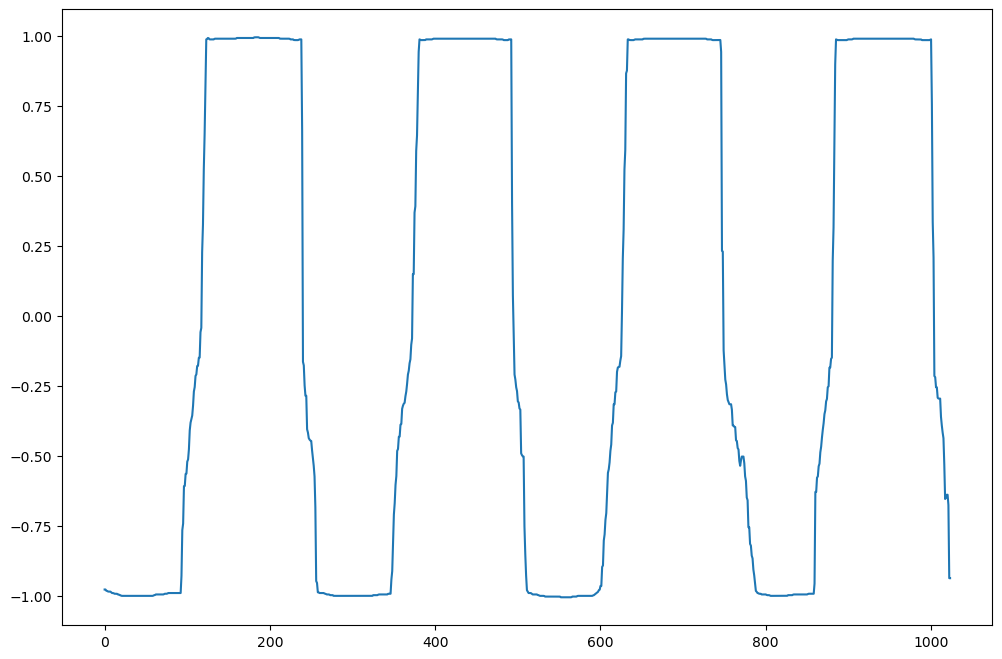

In [113]:


oldbbx,oldbbprofile = np.genfromtxt("oldbbprofile.csv", delimiter= ",")[:-2].T
n_periods = 4
uniquex, uniqueind = np.unique(oldbbx,return_index = True)
oldbbprofile = oldbbprofile[uniqueind]
oldbbsize = np.max(uniquex) - np.min(uniquex)

interpfuncbb = interp1d(uniquex, oldbbprofile)
bbx = np.linspace(np.min(uniquex), np.max(uniquex),1024)

bbprofile = interpfuncbb(bbx)
bbsize = np.max(bbx) - np.min(bbx)



# ftbb = np.abs(fft(exp(1j * phi2[19]/2 * bbprofile)))
# freqsbb = get_freqs(ftbb,bbsize)

# oldftbb = np.abs(fft(exp(1j * phi2[19]/2 * oldbbprofile)))
# oldfreqsbb = get_freqs(oldftbb,oldbbsize)

fig,ax1 = plt.subplots(figsize=(12,8))

# ax1.plot(oldbbprofile,"o-")
ax1.plot(bbprofile)


# ax1.plot(oldfreqsbb,oldftbb)
# ax1.plot(freqsbb,ftbb)
# ax1.set_xlim(-3e7,3e7)

plt.show()

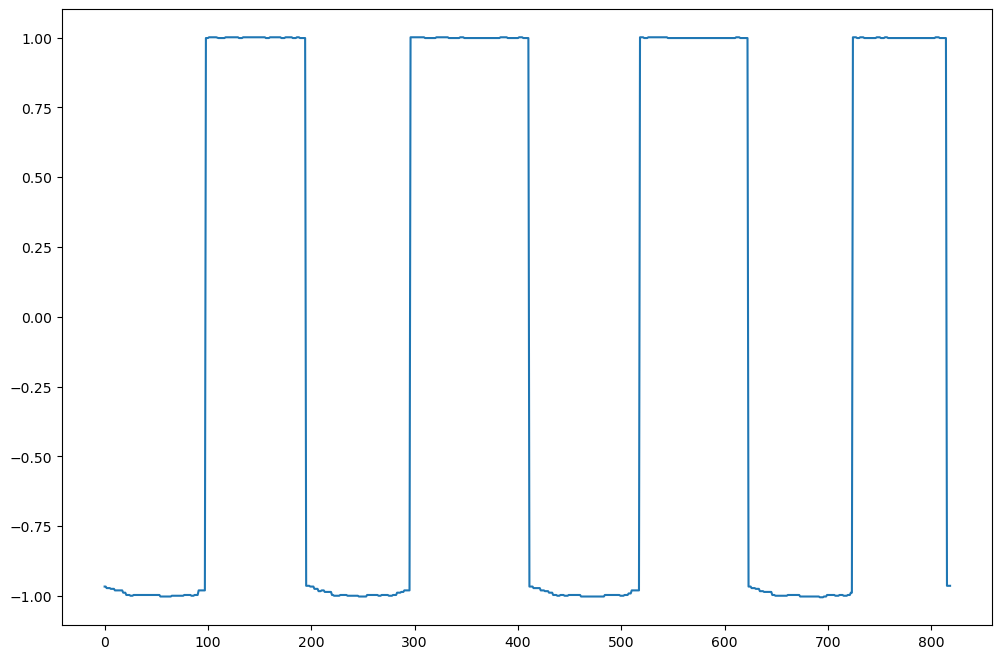

In [283]:
def smooth_profile(profile, pct_diff):
    for i in range(1,len(profile)-1):
        a,b,c = profile[i-1], profile[i], profile[i+1]
        if b != 0:
            if abs((b - a)/b) > (pct_diff/100.0) and abs((b- c)/b) > (pct_diff/100.0):
                profile[i] = (a+c)/2
    return profile


oldrectangulargx, oldrectangularprofile = np.genfromtxt("oldrectprofile.csv", delimiter = ",")[:-1].T

oldruniquex, oldruniqueind = np.unique(oldrectangulargx,return_index=True)
oldrectangularprofile = oldrectangularprofile[oldruniqueind]


oldrsize = np.max(oldruniquex) - np.min(oldruniquex) 


oldrprofile = smooth_profile(oldrectangularprofile, 50)



fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(oldrprofile, "-")



plt.show()
plt.close(fig)

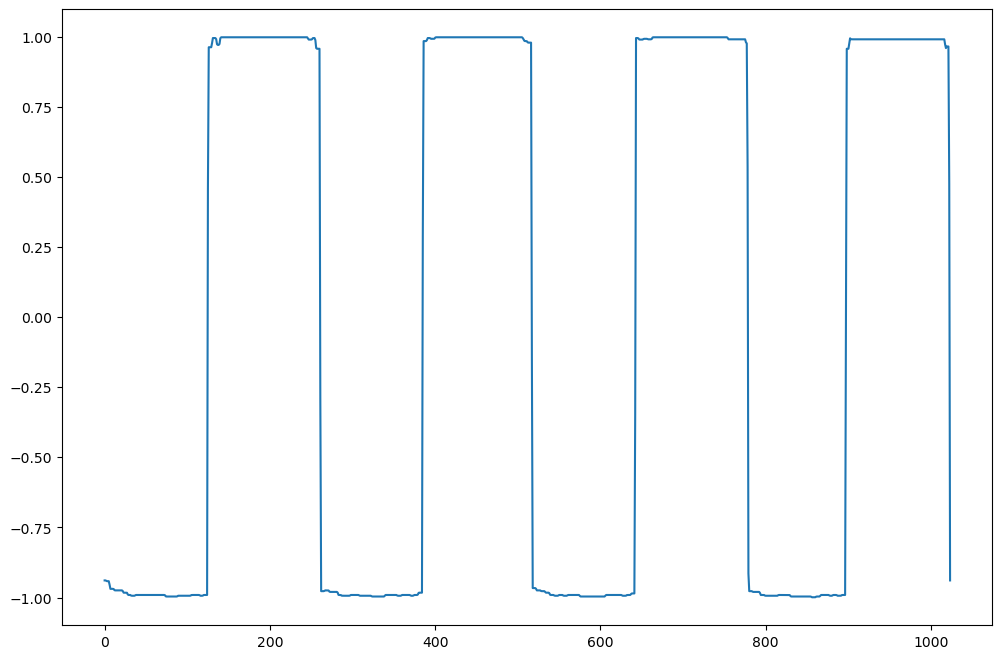

In [284]:
rx, rprofile = np.genfromtxt("rectprofile.csv", delimiter = ",")[:-1].T
rux, testind = np.unique(rx,return_index=True)
rprofile = smooth_profile(rprofile[testind],10)


rprofile[488:492] = 0.99
rprofile[560:576] = 0.99
rprofile[670:755] = 0.99


interpfuncr = interp1d(np.linspace(rux[0],rux[-1],len(rprofile)),rprofile)

rprofile = interpfuncr(np.linspace(rux[0],rux[-1],1024))

rsize = np.max(rux) - np.min(rux)


fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(rprofile,"-")



# ftr = np.abs(fft(exp(1j*phi2[19]/2 * rprofile),norm = "forward"))
# freqsr = get_freqs(ftr,rsize)
# ax1.plot(freqsr,ftr)
# ax1.plot(freqsi, fti,label = "Ideal G(x)")
# plt.xlim(-3e7,3e7)


plt.show()
plt.close(fig)

### Rotation Testing

In [116]:

t0 = time()
# bbdeg = np.arange(3.9,4.2,0.05)
bbdeg = np.array([4.05])
# rdeg = np.arange(1,5,1)
rdeg = np.array([0])




RotatedBB = RotatedSpectrum(bbdeg,bbprofile,bbsize,h2,p)
RotatedRect = RotatedSpectrum(rdeg,rprofile,rsize,h1,p)

rotbbprofiles = RotatedBB.rotated_profiles
rotrprofiles = RotatedRect.rotated_profiles

print(time() - t0, "seconds")




2.0992493629455566 seconds


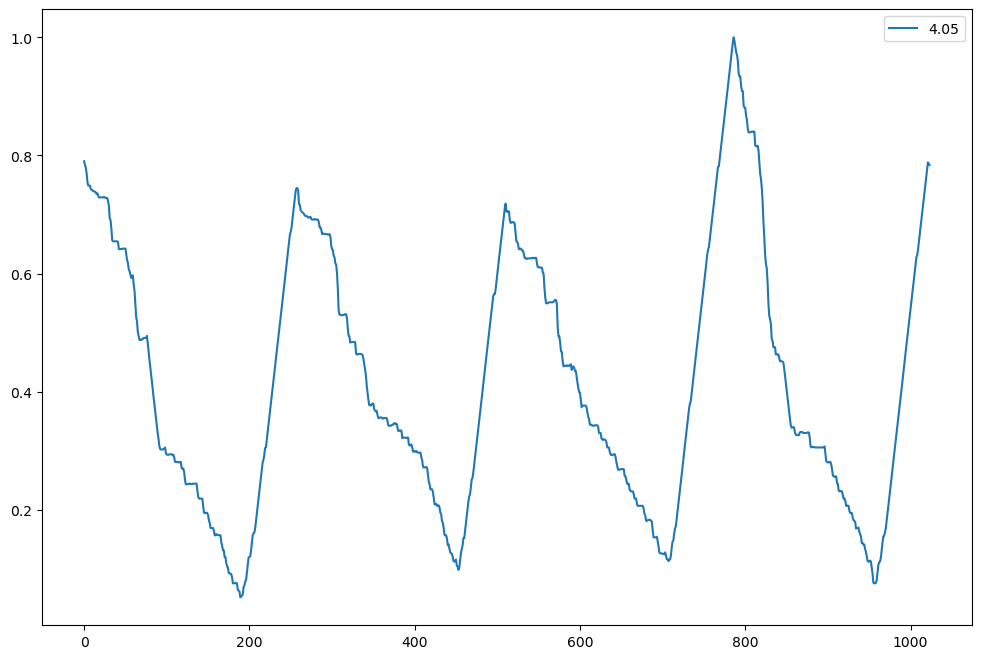

In [117]:



fig,ax = plt.subplots(figsize = (12,8))

[ax.plot(rotbbprofiles[i], label = bbdeg[i]) for i,_ in enumerate(bbdeg)]
# ax.plot(rotbbprofiles[0])
# [ax.plot(rotrprofiles[i], label = rdeg[i]) for i,_ in enumerate(rdeg)]

# ax.plot(rotrprofiles[0])
# plt.xlim(0,3000)



ax.legend()
plt.show()


plt.close(fig)

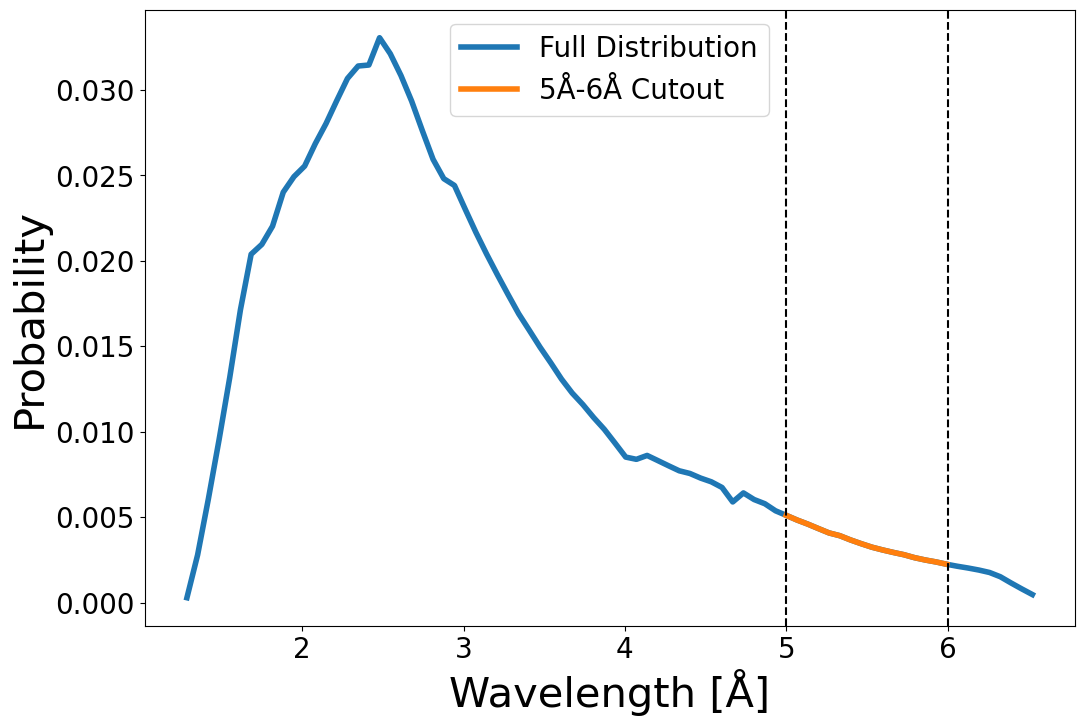

In [2388]:
fig, ax1 = plt.subplots(figsize  = (12,8))

# ax1.plot(polyspectrum[0]*1e10,polyspectrum[1],lw = 4)
ax1.plot(jplam*1e10, jpplam, lw = 4, label = "Full Distribution")
ax1.plot(jplam[cutout_mask]*1e10, jpplam[cutout_mask], lw = 4, label = "5Å-6Å Cutout")

ax1.set_xlabel("Wavelength [Å]", fontsize = 30)
ax1.set_ylabel("Probability", fontsize = 30)
ax1.tick_params(labelsize = 20)
ax1.axvline(5,color = "k", ls = "--")
ax1.axvline(6,color = "k", ls = "--")

ax1.legend(fontsize = 20, loc = "upper center")
# fig.savefig("jparcwavelengthdistwithcutout.png")

plt.show()
plt.close(fig)

### 2PGMI PhysRevA


In [276]:
p = 2.4e-6
L1mono = 1.2
L1bi = 1.73
L1poly = 4.65

L0mono = -0.05
L0bi = 0.01
L0poly = 0.44
d0 = {"mono": -0.75e-3, "bi": +0.8e-3, "poly": -0.38e-3}


Lmono = 2.99 - L0mono
Lbi = 3.52 - L0bi
Lpoly = 8.8 - L0poly


polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9

lammono = np.array([4.4e-10])
plammono = np.array([1])

lambi = np.array([4.4e-10,2.2e-10])
plambi = np.array([3.2/4.2,1/4.2])

lampoly, plampoly = polyspectrum.copy()


mt = 5
x0 = np.array([0])

Nbc = 5e28*4.149e-15
h = 0.27*pi / (Nbc*4.4e-10)
hpoly = 0.2*pi / (Nbc*5e-10)

phimono = Nbc*lammono*h
phibi = Nbc*lambi*h

phipoly = Nbc*lampoly*hpoly


camsize = 2.5e-2
slitx = 230e-6
# slitxrange = np.linspace(180,300,13)*1e-6
slitxpoly = 590e-6
# slitxpolyrange = np.linspace(450,600,16)*1e-6


slity = 100e-6
xbin = 1e-6
ybin = 1e-6
res = 100e-6
respoly = 150e-6


G1sdmono = {"p":p, "L1": np.array([L1mono]), "phi":phimono}
G1sdmono["L2"] = np.linspace(7,16,19)*1e-3 + d0["mono"]


G2sdmono = {"p":p, "L1": G1sdmono["L1"] +  G1sdmono["L2"], "phi":phimono}
G2sdmono["L2"] = Lmono - (G1sdmono["L1"] + G1sdmono["L2"])

G1sdbi = {"p":p, "L1": np.array([L1bi]), "phi":phibi}
G1sdbi["L2"] = np.linspace(7,16,10)*1e-3 + d0["bi"]


G2sdbi = {"p":p, "L1": G1sdbi["L1"] +  G1sdbi["L2"], "phi":phibi}
G2sdbi["L2"] = Lbi - (G1sdbi["L1"] + G1sdbi["L2"])


G1sdpoly = {"p":p, "L1": np.array([L1poly]), "phi":phipoly}
G1sdpoly["L2"] = np.linspace(7,16,10)*1e-3 + d0["poly"]


G2sdpoly = {"p":p, "L1": G1sdpoly["L1"] +  G1sdpoly["L2"], "phi":phipoly}
G2sdpoly["L2"] = Lpoly - (G1sdpoly["L1"] + G1sdpoly["L2"])


# Ioff = np.linspace(-5000,5000,10)
simaptsmono = {"G1":RectGrating(G1sdmono),"G2":RectGrating(G2sdmono)}
siminitmono = {"lam":lammono, "plam": plammono, "L":Lmono,"d":G1sdmono["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "slity" : slity, "res": res, "batches" : 2000}

simaptsbi = {"G1":RectGrating(G1sdbi),"G2":RectGrating(G2sdbi)}
siminitbi = {"lam":lambi, "plam": plambi, "L":Lbi,"d":G1sdbi["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "slity" : slity, "res": res, "batches" : 2000}

simaptspoly = {"G1":RectGrating(G1sdpoly),"G2":RectGrating(G2sdpoly)}
siminitpoly = {"lam":lampoly, "plam": plampoly, "L":Lpoly,"d":G1sdpoly["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitxpoly, "slity" : slity, "res": respoly, "batches" : 2000}


(2000, 19, 12) after parallel
(19, 24000) after reshape
(19, 24000) before convolution


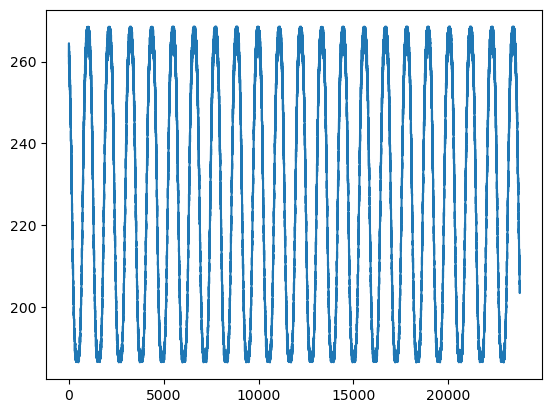

Finding contrast
(2000, 10, 2, 12) after parallel
(10, 2, 24000) after reshape
(10, 24000) before convolution


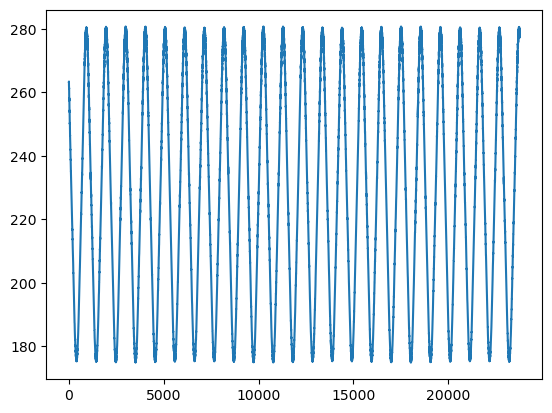

Finding contrast
(2000, 10, 41, 12) after parallel
(10, 41, 24000) after reshape
(10, 24000) before convolution


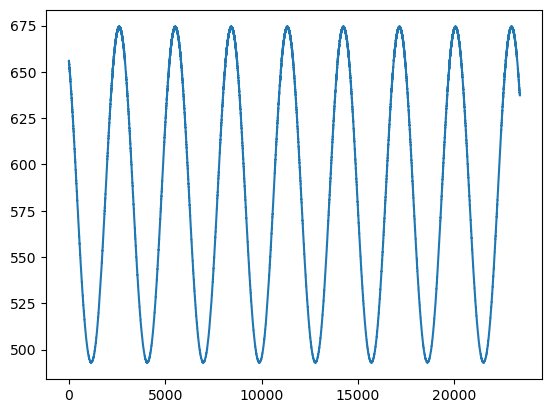

Finding contrast
59.807814598083496 seconds


In [277]:
t0 = time()

simmono = PGMI(simaptsmono,siminitmono)
simmono.propagate_to("G1")
simmono.propagate_to("G2")
simmono.generate_after("G2")

simbi = PGMI(simaptsbi,siminitbi)
simbi.propagate_to("G1")
simbi.propagate_to("G2")
simbi.generate_after("G2")

simpoly = PGMI(simaptspoly,siminitpoly)
simpoly.propagate_to("G1")
simpoly.propagate_to("G2")
simpoly.generate_after("G2")

print(time() - t0, "seconds")


In [278]:
monocont = simmono.get_value("contrast")
bicont = simbi.get_value("contrast")
polycont = simpoly.get_value("contrast")

monofitparams = simmono.get_value("fitparams")
bifitparams = simbi.get_value("fitparams")
polyfitparams = simpoly.get_value("fitparams")

### 3PGMI PRL 

In [286]:

p = 2.4e-6
L = 8.8

lam = np.array([5e-10])
plam = np.array([1])

polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9
# lam,plam = polyspectrum.copy()

x0 = np.array([0])



mt = 5


Nbc = 5e28*4.149e-15
h1,h2,h3 = 15.8e-6,29e-6,15.8e-6

phi1,phi2,phi3 = Nbc*lam*h1,Nbc*lam*h2,Nbc*lam*h3
idealgrating_phase_offset = -413*pi/440


camsize = 1e-2
slitx = 500e-6
slity = 100e-6

xbin = 1e-6
ybin = 25e-6

res = 150e-6
d1 = 4.6e-2
L1 = 4.75
d3pgmi = np.linspace(2,7,51)*1e-2 


G1sd = {"p":p, "L1": np.array([L1-d1]), "phi":phi1, "phase_offset": idealgrating_phase_offset}
G1sd["L2"] = np.array([d1])

G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi":phi2, "phase_offset": idealgrating_phase_offset}


G2sd["L2"] = d3pgmi
# G2sd["L2"] = np.array([-1.2,-1,-0.8,0.8,1,1.2])*1e-2 + d1

G2sd["L2"][G2sd["L2"] == d1] = d1 + 5e-5

G3sd = {"p":p, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "phase_offset": idealgrating_phase_offset}
G3sd["L2"] = np.array([L]) - G3sd["L1"] 

simaptsideal = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}

# simaptsideal = {"G1":RectGrating(G1sd),"G2":Sample(G2sd,10*p,grating_equation(np.linspace(0,10*p,1001),p,0)),"G3":RectGrating(G3sd)}


simaptsrect = {"G1":GratingFromImage(G1sd, rsize, rprofile),\
                      "G2":GratingFromImage(G2sd,rsize,rprofile),\
           "G3":GratingFromImage(G3sd,rsize, rprofile)}



# simaptsbb = {"G1":GratingFromImage(G1sd, rsize, rprofile),\
#                       "G2":Sample(G2sd,bbsize,np.array(rotbbprofiles)),\
#            "G3":GratingFromImage(G3sd,rsize, rprofile)}







siminit = {"lam":lam, "plam":plam, "L":L,"d":G2sd["L2"]-d1,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin ,"pos":np.array([[0],[1]]),\
           "camsize" : camsize ,"convmode" : "valid", "slitx": slitx,"slity" : slity, "res": res, "batches" : 500  }

(5000, 51, 2) after parallel
(51, 10000) after reshape
(51, 10000) before convolution


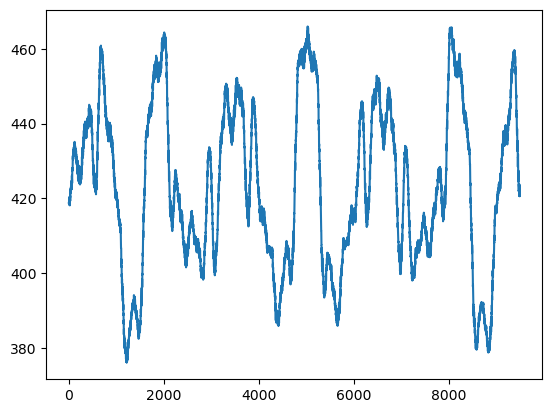

Finding contrast
40.95769119262695 seconds


In [287]:
t0 = time()

# simideal = PGMI(simaptsideal,siminit)
# simideal.propagate_to("G1")
# simideal.propagate_to("G2")
# simideal.propagate_to("G3")
# simideal.generate_after("G3")


simrect = PGMI(simaptsrect,siminit)
simrect.propagate_to("G1")
simrect.propagate_to("G2")
simrect.propagate_to("G3")
simrect.generate_after("G3")

# I3bb0255ordneg4sample = []
# cont3bb0255ordneg4sample = []
# fitparams3bb0255ordneg4sample = []

# for i, d in enumerate(d3pgmi):
    

#     G2sd["L2"] = np.array([d])
#     # G2sd["L2"] = np.array([-1.2,-1,-0.8,0.8,1,1.2])*1e-2 + d1

#     G2sd["L2"][G2sd["L2"] == d1] = d1 + 5e-5

#     G3sd = {"p":p, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "phase_offset": idealgrating_phase_offset}
#     G3sd["L2"] = np.array([L]) - G3sd["L1"] 

#     simaptsideal = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}

#     # simaptsideal = {"G1":RectGrating(G1sd),"G2":Sample(G2sd,10*p,grating_equation(np.linspace(0,10*p,1001),p,0)),"G3":RectGrating(G3sd)}


#     simaptsrect = {"G1":GratingFromImage(G1sd, rsize, rprofile),\
#                           "G2":GratingFromImage(G2sd,rsize,rprofile),\
#                "G3":GratingFromImage(G3sd,rsize, rprofile)}



#     simaptsbb = {"G1":GratingFromImage(G1sd, rsize, rprofile),\
#                           "G2":Sample(G2sd,bbsize,np.array(rotbbprofiles)),\
#                "G3":GratingFromImage(G3sd,rsize, rprofile)}







#     siminit = {"lam":lam, "plam":plam, "L":L,"d":G2sd["L2"]-d1,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin ,"pos":np.array([[0],[1]]),\
#                "camsize" : camsize ,"convmode" : "valid", "slitx": slitx,"slity" : slity, "res": res, "batches" : 12500  }
    
#     simbb = PGMI(simaptsbb,siminit)
#     simbb.propagate_to("G1")
#     simbb.propagate_to("G2")
#     simbb.propagate_to("G3")
#     simbb.generate_after("G3")
#     I3bb0255ordneg4sample.append([simbb.get_value("intensity")])
#     cont3bb0255ordneg4sample.append([simbb.get_value("contrast")])
#     fitparams3bb0255ordneg4sample.append([simbb.get_value("fitparams")])
#     clear_output(wait = True)
#     print("%.2f %% done" % (i/len(d3pgmi)*100))
    

    



print(time() - t0, "seconds")


### 3PGMI Density Plots

In [ ]:

p = 2e-6
L = 8
# Ls = 3

lam = np.array([5e-10])
plam = np.array([1])

x0 = np.array([0])

mt = 5

Nbc = 5e28*4.149e-15

phi1,phi2,phi3 = np.pi/2, np.pi/2, np.pi/10

camsize = 2e-2
slitx = 200e-6

xbin = 1e-6
ybin = 1e-6

res = 100e-6
L1 = 4
dconst = 5e-2

d3pgmi = np.linspace(0.25,4.25,81) * p**2/lam

ps_vals = np.linspace(1,6,51)*1e-6



In [ ]:
t0 = time()
cont1withsample = []
I1withsample = []
fitp1withsample = []

# cont1nosample = []
# I1nosample = []
# fitp1nosample = []

for psample in ps_vals:
    
    psize = 10*psample
    
    profile = grating_equation(np.linspace(0,psize,1001),psample, 0)

    G1sd = {"p":p, "L1": np.array([L1]), "phi": np.array([phi1])}
    G1sd["L2"] = d3pgmi
#     print(G1sd["L1"], G1sd["L2"])


    G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi": np.array([phi2])}


    G2sd["L2"] = dconst - d3pgmi 
#     print(G2sd["L1"], G2sd["L2"])

    
    G3sd = {"p":psample, "L1": G2sd["L2"] + G2sd["L1"], "phi": np.array([phi3]), "mt":1, "spectrum_spacing":1}
    G3sd["L2"] = np.array([L]) - G3sd["L1"] 
    
#     print(G3sd["L1"], G3sd["L2"])

#     G1sd = {"p":p, "L1": np.array([L1]), "phi": np.array([phi1])}
#     G1sd["L2"] = d3pgmi


#     G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi": np.array([phi2])}


#     G2sd["L2"] = np.array([L]) - G2sd["L1"]

    


    simaptsdens = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":Sample(G3sd,psize,profile)}
    print(simaptsdens["G3"].get_value("p"))
    
#     simaptsdens = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}
    
#     simaptsdens = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd)}
    
    siminit = {"lam":lam, "plam":plam, "L":L,"d": d3pgmi  ,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin) + 1),"x0" : x0,"xbin":xbin,"ybin":ybin ,"pos":np.array([[0],[1]]),\
               "camsize" : camsize ,"convmode" : "valid", "slitx": slitx, "res": res, "batches" : 10000  }
    
    simdens = PGMI(simaptsdens,siminit)

    simdens.propagate_to("G1")
    simdens.propagate_to("G2")
    
#     simdens.generate_after("G2")

    simdens.propagate_to("G3")
    simdens.generate_after("G3")
    
    cont1withsample.append(simdens.contrast)
    I1withsample.append(simdens.intensity)
    fitp1withsample.append(simdens.fitparams)
    
#     cont1nosample.append(simdens.contrast)
#     I1nosample.append(simdens.intensity)
#     fitp1nosample.append(simdens.fitparams)
    
    plt.plot(d3pgmi*1e3,simdens.contrast)
    plt.show()
    
    
print(time() - t0, "seconds")


In [ ]:
cont1withsample = np.squeeze(cont1withsample)

fig, ax = plt.subplots(figsize = (12,8))
c = ax.imshow(cont1withsample, aspect = "auto", origin = "lower", extent = [d3pgmi[0],d3pgmi[-1],ps_vals[0],ps_vals[-1]])

# ax.set_xticks(d3pgmi[::len(d3pgmi)//2])
# ax.set_xticklabels([r"$\frac{p^{2}}{4\lambda}$",r"$\frac{3p^{2}}{2\lambda}$",r"$\frac{L}{2}$",r"$\frac{4p^{2}}{\lambda}$"], fontsize = 12)


fig.colorbar(c)
plt.show()
plt.close(fig)

### 2PGMI Plots

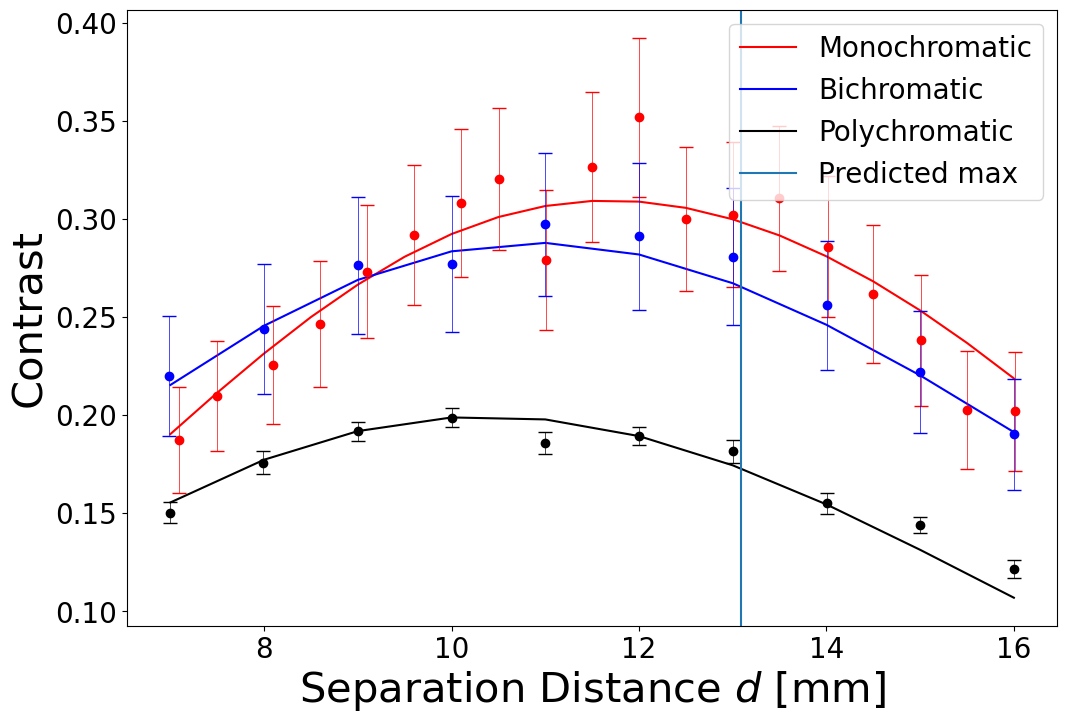

In [279]:
fig, ax1 = plt.subplots(figsize  = (12,8))

colours = ["red","blue", "black"]

ax1.plot((simmono.d - d0["mono"])*1e3, monocont, color = colours[0], label = r"Monochromatic")
ax1.plot((simbi.d -d0["bi"])*1e3, bicont, color = colours[1], label = r"Bichromatic")

ax1.plot((simpoly.d-d0["poly"] )*1e3, polycont, color = colours[2], label = r"Polychromatic")

plt.gca().set_prop_cycle(None)

ax1.errorbar(MONO_DATA[0],MONO_DATA[1],MONO_ERROR, fmt = "ro", elinewidth = 0.5,capsize = 5)
ax1.errorbar(BI_DATA[0]*1e3,BI_DATA[1],BI_ERROR, fmt = "bo", elinewidth = 0.5,capsize = 5)
ax1.errorbar(POLY_DATA[0]*1e3,POLY_DATA[1],POLY_ERROR, fmt = "ko", elinewidth = 0.5,capsize = 5)

ax1.axvline((p**2/lammono )* 1e3, label = "Predicted max")

ax1.legend(fontsize = 20, loc = "upper right")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax1.set_xlabel("Separation Distance $d$ [mm]", fontsize = 30)
ax1.set_ylabel("Contrast", fontsize = 30)

# ax1.set_title("Contrast vs. G1-G2 Separation, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
# fig.savefig("ContrastVsDfinal.png")
# ax1.set_xlim(0.55,9)
# plt.grid()
plt.show()
plt.close(fig)

### 3PGMI Plots

In [1190]:
I3bb0255ordneg4sample, fitparams3bb0255ordneg4sample = np.array(I3bb0255ordneg4sample).squeeze(),  np.array(fitparams3bb0255ordneg4sample).squeeze()

In [ ]:

for ind in range(I3bb0255ordneg4sample.shape[0]):
    # print(ind)
    fig, ax1 = plt.subplots(figsize  = (12,8))
    clear_output(wait= True)
#     theorycurve = cosine_func(simbb.x, np.mean(I3bb[ind]), np.amax(I3bb[ind]) - np.mean(I3bb[ind]),\
#                                            L*p/simbb.d[ind],0)
    ax1.plot(simbb.x,I3bb0255ordneg4sample[ind], label = "Sim, $D_{23}$ - $D_{12}$ = %.2f mm" % ((d3pgmi[ind] - d1)*1e3))
    ax1.plot(simbb.x,cosine_func(simbb.x, *fitparams3bb0255ordneg4sample[ind]), label = "Fit, $D_{23}$ - $D_{12}$ = %.2f mm" % ((d3pgmi[ind] - d1)*1e3))
#     ax1.plot(simbb.x, theorycurve, label = "Theory, $D_{23}$ - $D_{12}$ = %.2f mm" % (simbb.d[ind]*1e3) )
#     theorycurves.append(theorycurve)
    ax1.legend(loc = "upper right")
    # ax1.set_xlim(5e-3,10e-3)
    ax1.set_ylim()
    ax1.set_title("C = %.3f%%" % (np.squeeze(cont3bb0255ordneg4sample)[ind]*100), fontsize = 35)
    plt.pause(0.5)
#     ax1.cla()
    plt.show()
    plt.close(fig)
    
    

In [288]:
# cont3polyrect5 = simrect.contrast
cont3monorect5 = simrect.contrast
# cont3monorect = simrect.contrast

In [197]:
# cont3polyrect5[np.argmax(cont3polyrect5)] = 0 


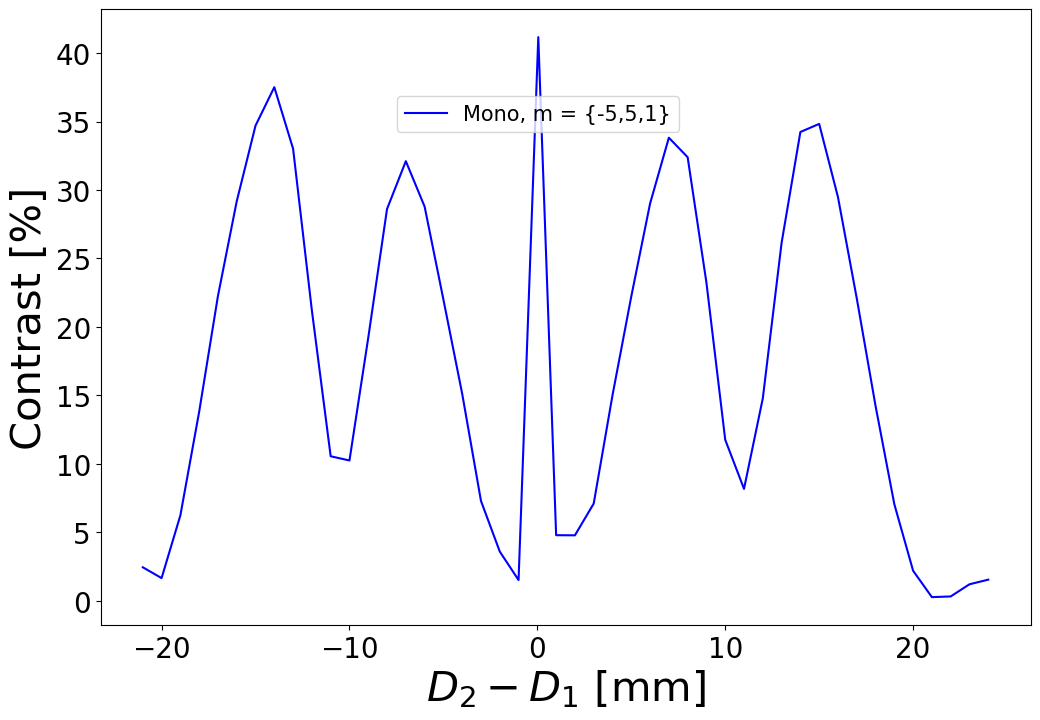

In [289]:
fig, ax1 = plt.subplots(figsize  = (12,8))

ax1.set_prop_cycle(color = ["blue","red","black"])

# ax1.plot(simrect.d[np.argmin(np.abs(simrect.d + 21e-3)):]*1e3, cont3monorect[np.argmin(np.abs(simrect.d + 21e-3)):]*1e2, label = "Mono, m = {-1,1,1}")


ax1.plot(simrect.d[np.argmin(np.abs(simrect.d + 21e-3)):]*1e3, cont3monorect5[np.argmin(np.abs(simrect.d + 21e-3)):]*1e2, label = "Mono, m = {-5,5,1}")
# ax1.plot(simrect.d[np.argmin(np.abs(simrect.d + 21e-3)):]*1e3, cont3polyrect5[np.argmin(np.abs(simrect.d + 21e-3)):]*1e2, label = "Poly, m = {-5,5,1}")


# ax1.plot(simbb.d[8:-4]*1e3, cont3bb5[8:-4], label = "5 order Bat rotated %.1f degrees" % abs(bbdeg))



# ax1.plot(prld,prlcont, "rx", label = "Data")
# ax1.set_ylim(0,0.04)



# ax2 = ax1.twinx()


# ax2.plot(simrect.d[5:-4]*1e3, freq3monorect[5:-4], label = "All Rectangular Gratings")

# ax2.plot(simrect.d[5:-3]*1e3, freq3monorect5[5:-3], label = "All Rectangular Gratings")


# ax2.plot(simbb.d[5:-3]*1e3, freq3bb[5:-3], "b-",  label = "G2 rotated %.2f degrees" % abs(bbdeg))


# ax2.plot(simrect.d*1e3, abs(1/fitparams3rect5[:,2]) / (1000), "o", label = "All Rectangular Gratings")




# ax2.plot(prld,prlfreq, "bo", label = "Experimental Data")


# ax2.plot(simbb.d*1e3, abs(simbb.d / (L*p*1e3)), label = r"$\frac{d}{Lp}$")

ax1.legend(loc = (0.3185,0.8), fontsize = 15)
# ax2.legend(loc = "upper left", fontsize = 20)

ax1.set_xlabel(r"$D_2 - D_1$ [mm]", fontsize = 30)
ax1.set_ylabel("Contrast [%]", fontsize = 30)
# ax2.set_ylabel(r"Frequency $[mm^{-1}]$", fontsize = 30)
# ax1.set_title("Contrast vs. G2-G3 Separation, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
ax1.tick_params(labelsize = 20)
# ax2.tick_params(labelsize = 20)


fig.savefig("3PGMIrectmonoandpoly1and5orders.png")

plt.show()
plt.close(fig)

### JPARC Data Analysis

In [24]:
def process_tfl(imgarr, rot_deg, medfilt_window):
    imgarr[~np.isfinite(imgarr)] = 0
    ycut,xcut = (np.array(imgarr.shape) * np.tan(np.radians(rot_deg))).astype(int)
    return medfilt2d(np.array(Image.fromarray(imgarr).rotate(rot_deg))[ycut:imgarr.shape[0] - ycut, xcut:imgarr.shape[1] - xcut],medfilt_window)

In [25]:
t0 = time()

exp1path = r"C:\Users\gabri\Documents\Python Scripts\JPARC experiment\exp1"

image_side = 2048


cm_per_pixel = 6/1944 # 6.32 cm camera total
rotdegs = [1.2,1,1,1,0.3,0]

# xlen_pxl, ylen_pxl = 750, 200

# regions_coords = np.array([[200,950,0,200], [image_side - 950, image_side - 200,0,200], [200,950,image_side - 200, image_side],\
#                   [image_side - 950,image_side-200, image_side - 200,image_side],[(image_side - 750)//2,  (image_side + 750)//2,(image_side - 200)//2, (image_side + 200)//2]])
# allfiltregions = []


# for i, coords in enumerate(regions_coords):
#     xstart,xend,ystart,yend = coords
#     allfiltregions.append([])
#     for j, path in enumerate(os.listdir(exp1path)):
#         allfiltregions[-1].append([process_tfl(img, rotdeg, 5) for img in np.array(tfl.imread(exp1path  + "\\" + path ))[...,ystart:yend,xstart:xend]]) 

# allfiltregions = np.array(allfiltregions)

# exp1region = np.array([np.array(tfl.imread(exp1path  + "\\" + i ))[...,ystart:yend,xstart:xend] for i in os.listdir(exp1path)])

# # exp1region = np.array([np.array(tfl.imread(exp1path  + "\\" + i )) for i in os.listdir(exp1path)])


# filtregion = np.empty((*exp1region.shape[:2],exp1region.shape[-2] - 40, exp1region.shape[-1] - 20))

# for i in range(exp1region.shape[0]):
#     for j in range(exp1region.shape[1]):
#         exp1region[i,j] = medfilt2d(exp1region[i,j],5)
#         filtregion[i,j] = np.array(Image.fromarray(exp1region[i,j]).rotate(rotdeg))[20 : exp1region.shape[-2] - 20, 10 : exp1region.shape[-1] - 10]




exp1filtered = np.array([[process_tfl(img, rotdegs[i], 5)[20:image_side - 100, 20:image_side - 100] for img in np.array(tfl.imread(exp1path  + "\\" + path))]\
                         for i, path in enumerate(os.listdir(exp1path))])



        
        




print(time() - t0, "seconds")


167.46329879760742 seconds


In [1055]:
monoindices[-1]

5

NameError: name 'monoindices' is not defined

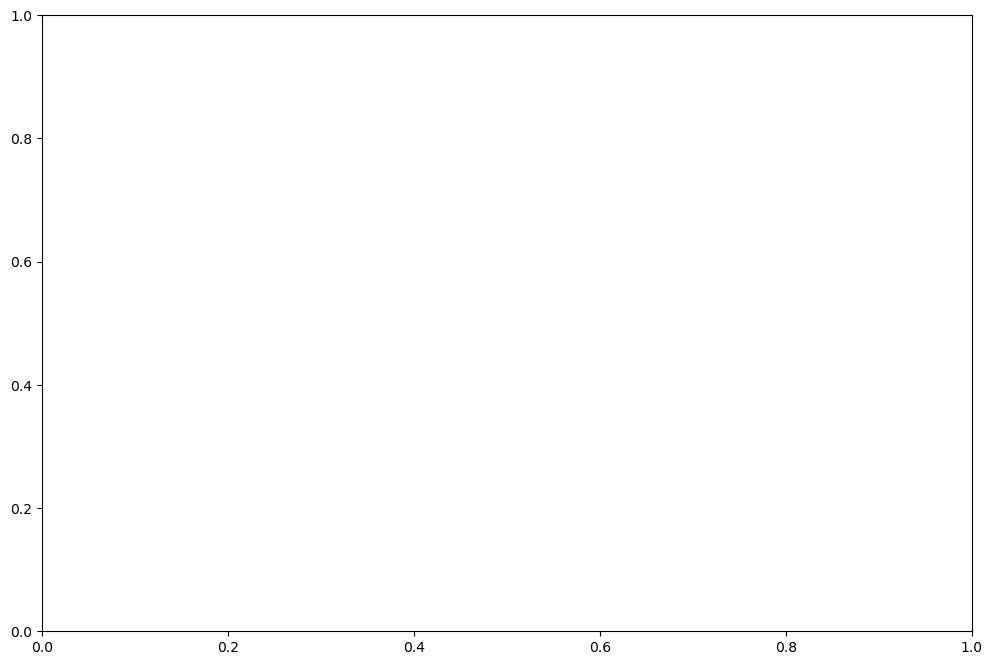

In [26]:
fig, ax1 = plt.subplots(figsize = (12,8))




c = ax1.imshow(exp1filtered[monoindices[-1],4], aspect = "auto")

ax1.axvline(960)
# plt.xlim(700,1200)
fig.colorbar(c)

ax1.set_xlabel("Camera x-axis (cm)")
ax1.set_ylabel("Camera y-axis (cm)")

# fig.savefig("sample.jpg")

plt.show()
plt.close(fig)

### Region Testing

In [28]:
contregion = np.empty((exp1filtered.shape[:2]))
Ldata = 8.2955
ddata = np.linspace(4.5,44.5,21)*1e-3
pdata = 3e-6

# for i in range(exp1filtered.shape[0]):
#     for j in range(exp1filtered.shape[1]):
#         IOI = exp1filtered[i,j]
#         IOIsh = IOI.shape
#         regionOI = IOI[IOIsh[0]//3:2*IOIsh[0]//3, IOIsh[1]//2:]
        

#         regionintens = np.sum(regionOI, axis = -2)
        
#         regionx = np.arange(len(regionintens))*cm_per_pixel*1e-2
        

#         regionfitparams = best_fit_moire_period(cosine_func, regionx, regionintens,pdata, Ldata, ddata[j])
#         contregion[i,j] = np.abs(regionfitparams[1]/regionfitparams[0])


In [34]:
t0 = time()

sh = exp1filtered.shape


region_a = exp1filtered[...,sh[-2]//3:2*sh[-2]//3, 2*sh[-1]//3: 5*sh[-1]//6]
region_b = exp1filtered[...,sh[-2]//3:2*sh[-2]//3, 5*sh[-1]//6:]
region_c = exp1filtered[...,sh[-2]//3:2*sh[-2]//3, sh[-1]//2:]

sh_a, sh_b, sh_c = region_a.shape,region_b.shape,region_c.shape

camx_a = np.linspace(0, sh_a[-1], sh_a[-1]) * cm_per_pixel *1e-2
camx_b = np.linspace(0, sh_b[-1], sh_b[-1]) * cm_per_pixel *1e-2
camx_c = np.linspace(0, sh_c[-1], sh_c[-1]) * cm_per_pixel *1e-2



exp1slice_a = abs(np.nanmean(region_a,axis = -2))
exp1slice_b = abs(np.nanmean(region_b,axis = -2))
exp1slice_c = abs(np.nanmean(region_c,axis = -2))




    


jpdatafitted_a = np.empty(exp1slice_a.shape)
jpdataparams_a = np.empty((*exp1slice_a.shape[:-1],4))

jpdatafitted_b = np.empty(exp1slice_b.shape)
jpdataparams_b = np.empty((*exp1slice_b.shape[:-1],4))

jpdatafitted_c = np.empty(exp1slice_c.shape)
jpdataparams_c = np.empty((*exp1slice_c.shape[:-1],4))



for i in range(exp1slice_a.shape[0]):
    for j in range(exp1slice_a.shape[1]):
            profile = exp1slice_a[i,j]
            jpdataparams_a[i,j] = best_fit_moire_period(cosine_func, camx_a, profile, pdata,Ldata,ddata[j])
            jpdatafitted_a[i,j] = cosine_func(camx_a,*jpdataparams_a[i,j])

for i in range(exp1slice_b.shape[0]):
    for j in range(exp1slice_b.shape[1]):
            profile = exp1slice_b[i,j]
            jpdataparams_b[i,j] = best_fit_moire_period(cosine_func, camx_b, profile, pdata,Ldata,ddata[j])
            jpdatafitted_b[i,j] = cosine_func(camx_b,*jpdataparams_b[i,j])

for i in range(exp1slice_c.shape[0]):
    for j in range(exp1slice_c.shape[1]):
            profile = exp1slice_c[i,j]
            jpdataparams_c[i,j] = best_fit_moire_period(cosine_func, camx_c, profile, pdata,Ldata,ddata[j])
            jpdatafitted_c[i,j] = cosine_func(camx_c,*jpdataparams_c[i,j])

datacont_a = np.abs(jpdataparams_a[...,1]/jpdataparams_a[...,0])
datafreq_a = 1/(jpdataparams_a[...,2])

datacont_b = np.abs(jpdataparams_b[...,1]/jpdataparams_b[...,0])
datafreq_b = 1/(jpdataparams_b[...,2])

datacont_c = np.abs(jpdataparams_c[...,1]/jpdataparams_c[...,0])
datafreq_c = 1/(jpdataparams_c[...,2])

datacont, datafreq = datacont_c,datafreq_c
print(time() - t0, "seconds")

31.886953830718994 seconds


NameError: name 'camx' is not defined

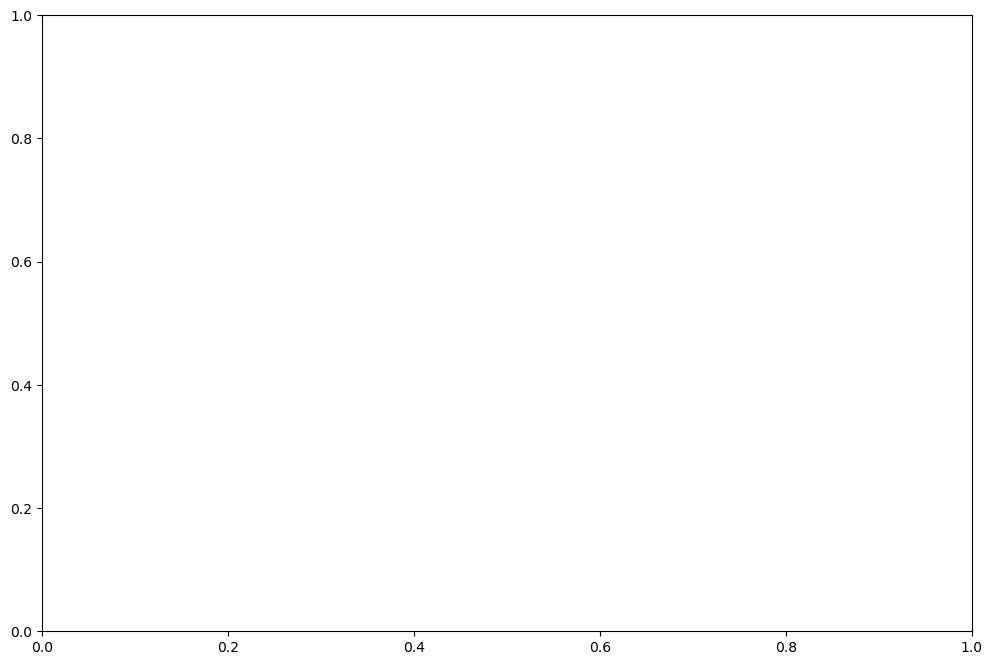

In [30]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(camx,exp1slice[0,9])
ax1.plot(camx,jpdatafitted[0,9])


plt.show()

In [35]:
def lin_func(d,d0,L,L0,p):
    return (d - d0)/((L-L0)*p)

def get_outlier_mask(data_arr,outlier_indices):
    mask = np.full(data_arr.shape,True)
    for i in range(data_arr.shape[0]):
        for ind in outlier_indices[i]:
            mask[i,ind] = False
    return mask




In [36]:


runs = [re.findall('[0-9]+', i)[0] for i in os.listdir(exp1path)]

monoindices = [runs.index(i) for i in runs if int(i) % 4 == 0]

cont5pcmaskmono = datacont[monoindices] > 0.05

monodatafreq = datafreq[monoindices]


d0mono, L0mono = np.array([curve_fit(lambda d,d0,L0: lin_func(d,d0,Ldata,L0,pdata), ddata[cont5pcmaskmono[i]], monodatafreq[i,cont5pcmaskmono[i]], p0 = [-2e-3,-10e-2],\
                    maxfev = 10000)[0] for i, monoind in enumerate(monoindices)]).T


# print("d0 (mm): ", d0mono*1e3)

polyindices = [runs.index(i) for i in runs if int(i)%2 != 0]

polydatafreq = datafreq[polyindices]

cont5pcmaskpoly = datacont[polyindices] > 0.05


d0poly, L0poly = np.array([curve_fit(lambda d,d0, L0: lin_func(d,d0,Ldata,L0,pdata),ddata[cont5pcmaskpoly[i]], polydatafreq[i,cont5pcmaskpoly[i]], p0 = [-2e-3,-10e-2],\
                    maxfev = 10000)[0] for i, polyind in enumerate(polyindices)]).T

# print("d0 (mm): ", d0poly*1e3)

L0data = np.mean([L0mono,L0poly])

d0mono = np.array([curve_fit(lambda d,d0: lin_func(d,d0,Ldata,L0data,pdata), ddata[cont5pcmaskmono[i]], monodatafreq[i,cont5pcmaskmono[i]], p0 = [-2e-3],\
                    maxfev = 10000)[0] for i, monoind in enumerate(monoindices)]).squeeze()
d0poly = np.array([curve_fit(lambda d,d0: lin_func(d,d0,Ldata,L0data,pdata),ddata[cont5pcmaskpoly[i]], polydatafreq[i,cont5pcmaskpoly[i]], p0 = [-2e-3],\
                    maxfev = 10000)[0] for i, polyind in enumerate(polyindices)]).squeeze()

# print("d0 (mm): ", d0mono*1e3)

# print("d0 (mm): ", d0poly*1e3)

d0data = np.mean([d0mono,d0poly], axis = 0)

print(d0data*1e3)


[-1.90848123 -2.20126324 -1.66364349]


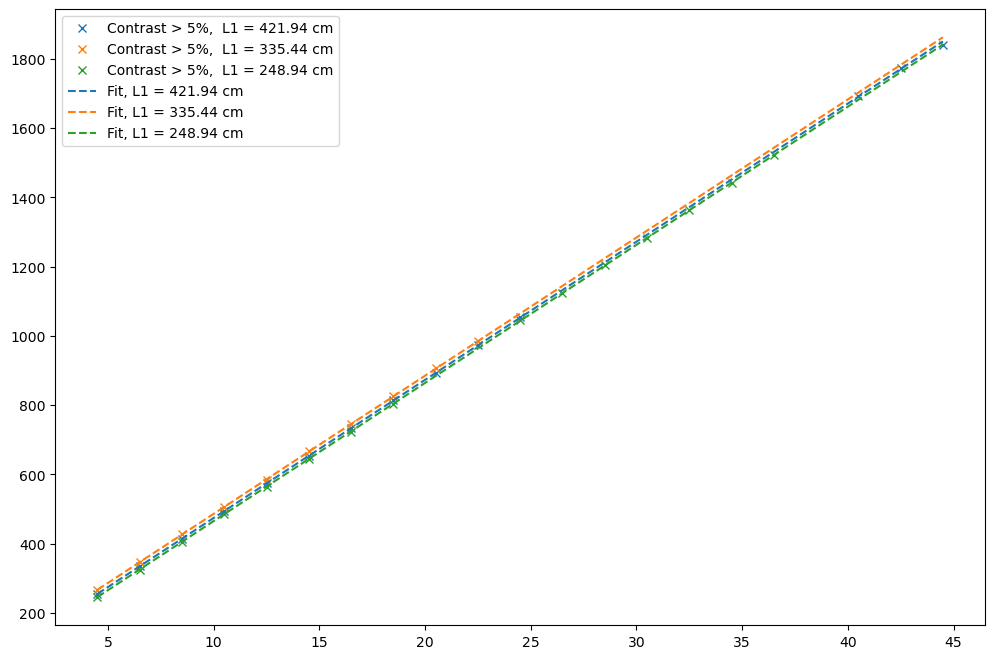

In [39]:
fig, ax1 = plt.subplots(figsize = (12,8))

# [ax1.plot(ddata*1e3,monodatafreq[i],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]
# ax1.set_prop_cycle(None)

[ax1.plot(ddata[cont5pcmaskmono[i]]*1e3,monodatafreq[i][cont5pcmaskmono[i]],"x", label = "Contrast > 5%%,  L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]

ax1.set_prop_cycle(None)

[ax1.plot(ddata*1e3,lin_func(ddata,d0mono[i],Ldata,L0data,pdata),"--", label = "Fit, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]


ax1.legend()

plt.show()
plt.close(fig)

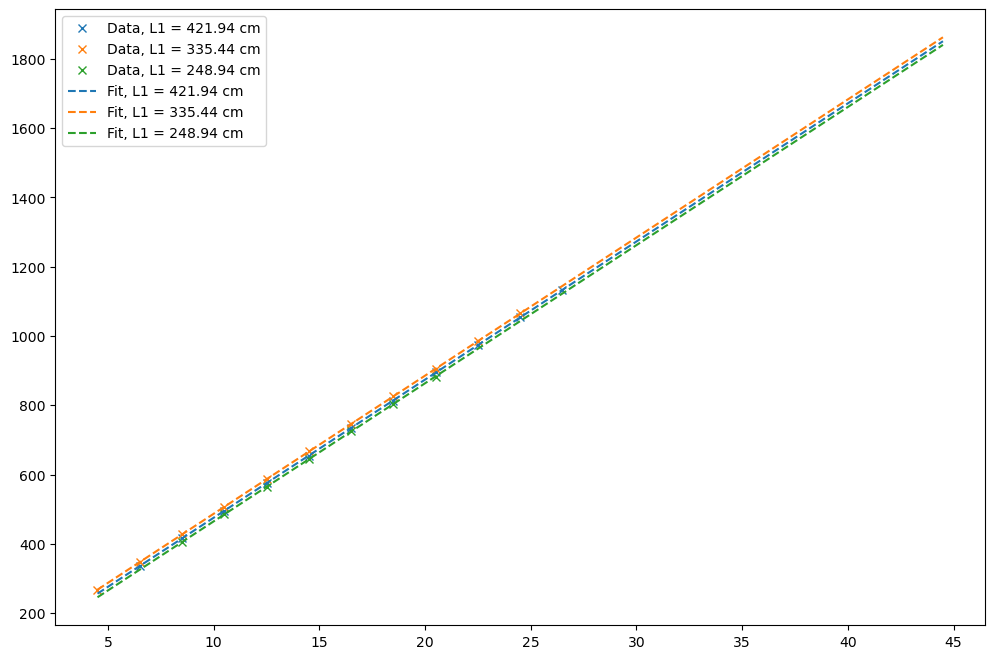

In [40]:


fig, ax1 = plt.subplots(figsize = (12,8))

# [ax1.plot(ddata*1e3,polydatafreq[i],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[i] * 1e2)) for i, polyind in enumerate(polyindices)]


[ax1.plot(ddata[cont5pcmaskpoly[i]]*1e3,polydatafreq[i][cont5pcmaskpoly[i]],"x", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]

ax1.set_prop_cycle(None)

[ax1.plot(ddata*1e3,lin_func(ddata,d0poly[i],Ldata,L0data,pdata),"--", label = "Fit, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]

ax1.legend()
# plt.xlim(24,47)
# plt.ylim(800,1900)
plt.show()



### JPARC Simulations


In [90]:
TOF, TOFcounts = np.array(pd.read_excel("neutronTOF_run19771.xlsx", usecols = (2,3),skiprows = (0,1))).T
TOF, TOFcounts = TOF[::4], TOFcounts[::4]

TOF *= 1e-3
TOFcountsarea = np.trapz(TOFcounts) # area under curve
TOFcountsnormed = TOFcounts/TOFcountsarea # sum is 1

TOF = TOF[TOFcountsnormed > 2e-4]
jpplam = TOFcountsnormed[TOFcountsnormed > 2e-4]

def TOFtolambda(TOF, planck_const, mass, detector_dist):
    return TOF * planck_const / (mass * detector_dist)


m_neu = 1.6749275e-27
planck_const = 6.6261e-34
detector_dist = 23.854



jplam = TOFtolambda(TOF, planck_const, m_neu, detector_dist)

cutout_mask = (jplam >= 5e-10) & (jplam <= 6e-10)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


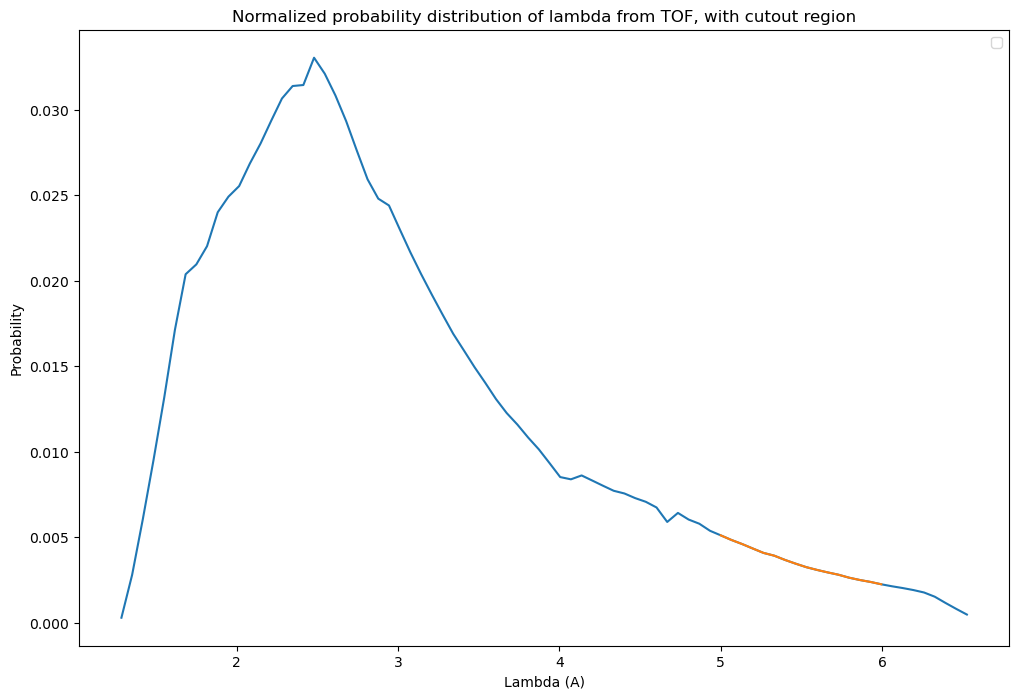

In [91]:
fig, ax1 = plt.subplots(figsize  = (12,8))

ax1.plot(jplam*1e10, jpplam)
ax1.plot(jplam[cutout_mask]*1e10, jpplam[cutout_mask])


# plt.xlim(4.5,6.1)
ax1.set_xlabel("Lambda (A)")
ax1.set_ylabel("Probability")
ax1.set_title("Normalized probability distribution of lambda from TOF, with cutout region")
ax1.legend()
# fig.savefig("jplamdist.jpg")
plt.show()
plt.close(fig)

In [92]:
a*100

array([-20.,   5., -15.])

In [105]:
Nbc = 5e28*4.149e-15
mt = 5
x0 = 0

pjp = 3e-6
xbinjp = 1e-6
ybinjp = 1e-6

jpmonolam = jplam[cutout_mask]
jpmonoplam = jpplam[cutout_mask]


hjp = 8.53e-6
jpd = np.linspace(4.5,44.5,81)*1e-3 




a_vals = np.linspace(-60,60,25)*1e-2
a = a_vals[np.array([8,13,9])]

L1jp = (96.6 + 319)*1e-2 -  np.arange(0,3,1) * 0.865 - L0data



jpd,L1jp = force_broadcast(jpd,L1jp)


L1jp = L1jp - (jpd - jpd[0])/2


Ljp = 8.2955 - L0data



monophijp = Nbc*jpmonolam*hjp



jpcamsize = 1e-2

jpslits = np.linspace(400,600,9)*1e-6
jpslit = jpslits[2]

print(jpslit)

jpres = 100e-6




G1monosd = {"p":pjp, "L1": L1jp -a, "phi":monophijp}
G1monosd["L2"] = jpd - d0data


G2monosd = {"p":pjp, "L1": G1monosd["L1"] +  G1monosd["L2"], "phi":monophijp}
G2monosd["L2"] = Ljp - G2monosd["L1"]


simjpmonoapts = {"G1":RectGrating(G1monosd),"G2":RectGrating(G2monosd)}



simjpmonoinit = {"lam":jpmonolam, "plam" : jpmonoplam, "L":np.array([Ljp]),"d":G1monosd["L2"],"mt":mt, \
                 "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
                 "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),"camsize" : jpcamsize ,\
                 "convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 5000 }



0.00045


In [143]:
I0_arr

array([0.85, 0.85, 0.65])

In [106]:
t0 = time()

simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
simjpmono.propagate_to("G1")
simjpmono.propagate_to("G2")
simjpmono.generate_after("G2")




# contjpmonoaslit = []
# fitparamsjpmonoaslit = []

# contjpmonores = []
# fitparamsjpmonores = []


# for a in a_vals:
#     L1 = L1jp - a
#     G1monosd = {"p":pjp, "L1": L1, "phi":monophijp}
#     G1monosd["L2"] = jpd - d0data
    
    

#     G2monosd = {"p":pjp, "L1": G1monosd["L1"] +  G1monosd["L2"], "phi":monophijp}
#     G2monosd["L2"] = Ljp - G2monosd["L1"]
#     simjpmonoapts = {"G1":RectGrating(G1monosd),"G2":RectGrating(G2monosd)}
#     simjpmonoinit = {"lam":jpmonolam, "plam" : jpmonoplam, "L":np.array([Ljp]),"d":G1monosd["L2"],"mt":mt, \
#                  "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
#                  "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),"camsize" : jpcamsize ,\
#                  "convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 2000 }
    
#     for slit in jpslits:
        
#         contjpmonoaslit.append([])
#         fitparamsjpmonoaslit.append([])
#         simjpmonoinit["slitx"] = slit


#         simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
#         simjpmono.propagate_to("G1")
#         simjpmono.propagate_to("G2")
#         simjpmono.generate_after("G2")
#         contjpmonoaslit[-1].append(simjpmono.get_value("contrast"))
#         fitparamsjpmonoaslit[-1].append(simjpmono.get_value("fitparams"))
#     clear_output()
#     print(np.argwhere(a == a_vals)/len(a_vals)*100, "% done")


# for res in res_vals:
    
#     simjpmonoinit["res"] = res
#     simjpmono = PGMI(simjpmonoapts,simjpmonoinit)
#     simjpmono.propagate_to("G1")
#     simjpmono.propagate_to("G2")
#     simjpmono.generate_after("G2")
#     contjpmonores.append(simjpmono.get_value("contrast"))
#     fitparamsjpmonores.append(simjpmono.get_value("fitparams"))
    
print(time() - t0, "seconds")

(5000, 81, 3, 16, 2) after parallel
(81, 3, 16, 10000) after reshape
(81, 3, 10000) before convolution
Finding contrast
183.5865695476532 seconds


In [ ]:
Nbc = 5e28*4.149e-15


jppolylam = jplam.copy()
jppolyplam = jpplam.copy()


polyphijp = Nbc*jppolylam*hjp





G1polysd = {"p":pjp, "L1": L1jp, "phi":polyphijp}
G1polysd["L2"] = jpd


G2polysd = {"p":pjp, "L1": G1polysd["L1"] +  G1polysd["L2"], "phi":polyphijp}
G2polysd["L2"] = Ljp - G2polysd["L1"]


# Ioff = np.array([500])



simjppolyapts = {"G1":RectGrating(G1polysd),"G2":RectGrating(G2polysd)}

simjppolyinit = {"lam":jppolylam, "plam" : jppolyplam, "L":Ljp,"d":G1polysd["L2"],"mt":mt, "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
            "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),\
            "camsize" : jpcamsize ,"convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 2000, "Ioffset" : Ioff }


In [ ]:
t0 = time()
# simjppoly = PGMI(simjppolyapts,simjppolyinit)
# simjppoly.propagate_to("G1")
# simjppoly.propagate_to("G2")
# simjppoly.generate_after("G2")


# contjppolyslit = []
# fitparamsjppolyslit = []

contjppolyaslit = []
fitparamsjppolyaslit = []

# contjppolyres = []
# fitparamsjppolyres = []

# for slit in jpslits:
    
#     simjppolyinit["slitx"] = slit
#     simjppoly = PGMI(simjppolyapts,simjppolyinit)
#     simjppoly.propagate_to("G1")
#     simjppoly.propagate_to("G2")
#     simjppoly.generate_after("G2")
#     contjppolyslit.append(simjppoly.get_value("contrast"))
#     fitparamsjppolyslit.append(simjppoly.get_value("fitparams"))


for a in a_vals:
    L1 = L1jp - a
    G1polysd = {"p":pjp, "L1": L1, "phi":polyphijp}
    G1polysd["L2"] = jpd - d0data


    G2polysd = {"p":pjp, "L1": G1polysd["L1"] +  G1polysd["L2"], "phi":polyphijp}
    G2polysd["L2"] = Ljp - G2polysd["L1"]
        
    simjppolyapts = {"G1":RectGrating(G1polysd),"G2":RectGrating(G2polysd)}
    simjppolyinit = {"lam":jppolylam, "plam" : jppolyplam, "L":Ljp,"d":G1polysd["L2"],"mt":mt, "x": np.linspace(0,jpcamsize,int(jpcamsize/xbinjp) + 1),"x0" : x0,"xbin":xbinjp,\
            "y": np.linspace(0,jpcamsize,int(jpcamsize/ybinjp) + 1),"ybin":ybinjp,"pos":np.array([[0],[1]]),\
            "camsize" : jpcamsize ,"convmode" : "valid", "slitx": jpslit, "slity" : jpslit, "res": jpres, "batches": 2000}
    
    for slit in jpslits:
        contjppolyaslit.append([])
        fitparamsjppolyaslit.append([])
        simjppolyinit["slitx"] = slit

        simjppoly = PGMI(simjppolyapts,simjppolyinit)
        simjppoly.propagate_to("G1")
        simjppoly.propagate_to("G2")
        simjppoly.generate_after("G2")
        contjppolyaslit[-1].append(simjppoly.get_value("contrast"))
        fitparamsjppolyaslit[-1].append(simjppoly.get_value("fitparams"))
    clear_output()
    print(np.argwhere(a == a_vals)/len(a_vals)*100, "% done")
# for res in res_vals:
    
#     simjppolyinit["res"] = res
#     simjppoly = PGMI(simjppolyapts,simjppolyinit)
#     simjppoly.propagate_to("G1")
#     simjppoly.propagate_to("G2")
#     simjppoly.generate_after("G2")
#     contjppolyres.append(simjppoly.get_value("contrast"))
#     fitparamsjppolyres.append(simjppoly.get_value("fitparams"))
    
print(time() - t0, "seconds")

In [107]:
Ijpmono = simjpmono.get_value("intensity")
rawjpmono = simjpmono.get_value("raw")
contjpmono = simjpmono.get_value("contrast")
fitparamsjpmono = simjpmono.get_value("fitparams")
simfreqjpmono = 1/np.abs(fitparamsjpmono[...,2]) 


# Ijppoly = simjppoly.get_value("intensity")
# rawjppoly = simjppoly.get_value("raw")
# contjppoly = simjppoly.get_value("contrast")
# fitparamsjppoly = simjppoly.get_value("fitparams")
# simfreqjppoly = 1/np.abs(fitparamsjppoly[...,2]) 


In [1979]:

# contjpmonores, fitparamsjpmonores = np.array([contjpmonores]).squeeze(), np.array([fitparamsjpmonores]).squeeze()
# simfreqjpmonores = 1/np.abs(fitparamsjpmonores[...,2])
# contjppolyres, fitparamsjppolyres = np.array([contjppolyres]).squeeze(), np.array([fitparamsjppolyres]).squeeze()
# simfreqjppolyres = 1/np.abs(fitparamsjppolyres[...,2])

# contjpmonoaslit, fitparamsjpmonoaslit = np.array([contjpmonoaslit]).squeeze(), np.array([fitparamsjpmonoaslit]).squeeze()
# simfreqjpmonoaslit = 1/np.abs(fitparamsjpmonoaslit[...,2])
# contjppolyaslit, fitparamsjppolyaslit = np.array([contjppolyaslit]).squeeze(), np.array([fitparamsjppolyaslit]).squeeze()
# simfreqjppolyaslit = 1/np.abs(fitparamsjppolyaslit[...,2])

In [1984]:
# contjpmonoaslit = contjpmonoaslit.reshape(25,9,21,3)
# simfreqjpmonoaslit = simfreqjpmonoaslit.reshape(25,9,21,3)

# contjppolyaslit = contjppolyaslit.reshape(25,9,21,3)
# simfreqjppolyaslit = simfreqjppolyaslit.reshape(25,9,21,3)

### Minimization

In [108]:
scale_arr = np.linspace(0.25,1,76)
I0_arr = scale_arr[np.array([60,60,40])]
# scale_arr, contjpmonoaslit = force_broadcast(sc/ale_arr, contjpmonoaslit)
# contjpmonoaslit = contjpmonoaslit * scale_arr

# scale_arr, contjppolyaslit = force_broadcast(scale_arr, contjppolyaslit)
# contjppolyaslit = contjppolyaslit * scale_arr

# scale_arr, contjpblue = force_broadcast(scale_arr, contjpblue)
# contjpblue = contjpblue * scale_arr

In [1956]:
contjppolyaslit.shape

(76, 11, 21, 3)

In [2005]:
# contjpmonoaslit, datamonoconttemp = force_broadcast(contjpmonoaslit, datacont[monoindices].T)

# jpmonoerr = np.sum(np.abs(contjpmonoaslit - datamonoconttemp)**2, axis = -2)


# optimal_mono = np.array([min_index(jpmonoerr[...,i]) for i in range(3)]) 

# print(optimal_mono)


# contjppolyaslit, datapolyconttemp = force_broadcast(contjppolyaslit, datacont[polyindices].T)

# jppolyerr = np.sum(np.abs(contjppolyaslit - datapolyconttemp)**2, axis = -2)


# jptotalerr = []
# a_I0_indices = []

# for i in range(jpmonoerr.shape[-2]):
#     mono1,mono2,mono3 = jpmonoerr[...,i,0],jpmonoerr[...,i,1],jpmonoerr[...,i,2]
#     poly1,poly2,poly3 = jppolyerr[...,i,0],jppolyerr[...,i,1],jppolyerr[...,i,2]
#     tot1,tot2,tot3 = mono1+poly1,mono2+poly2,mono3+poly3
    
#     a_I0_indices.append([min_index(tot1),min_index(tot2),min_index(tot3)])
#     jptotalerr.append([tot1,tot2,tot3])
    
# a_I0_indices = np.array(a_I0_indices)
# jptotalerr = np.array(jptotalerr)
# print(min_index(jptotalerr))
# print(a_I0_indices[5])


# print(np.array(a_I0_indices))

# optimal_poly = np.array([min_index(jppolyerr[...,i]) for i in range(3)]) 

# print(optimal_poly)


# jptotalerr = jpmonoerr + jppolyerr 

# # print(jptotalerror.shape)
# optimal_inds = np.array([min_index(arr) for arr in jptotalerr]) 
# print(optimal_inds)


# contjpblue, datablueconttemp = force_broadcast(contjpblue, datacont[monoindices][0])
# print(contjpblue.shape)
# jpblueerr = np.sum(np.abs(contjpblue- datablueconttemp)*datablueconttemp, axis = -1)
# print(min_index(jpblueerr))

# fakedata = contjpblue[44,0,10,:]

# contjpblue, fakedata = force_broadcast(contjpblue, fakedata)
# print(contjpblue.shape)
# jpblueerr = np.sum(np.abs(contjpblue- fakedata), axis = -1)

# print(min_index(jpblueerr))

[[50  0  8]
 [58 11  8]
 [38 15  6]]
(6, 2, 40, 15)
[[46 24]
 [53 12]
 [37 16]]


In [2321]:
# fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(3,2,figsize = (12,18))

# c1 = ax1.imshow(jpmonoerr[75,...,0], aspect = "auto", extent = (jpslits[0],jpslits[-1],a_vals[-1], a_vals[0]), clim = (0,2))
# c2 = ax2.imshow(jppolyerr[75,...,0], aspect = "auto", extent = (jpslits[0],jpslits[-1],a_vals[-1], a_vals[0]), clim = (0,2))
# c3 = ax3.imshow(jpmonoerr[75,...,1], aspect = "auto", extent = (jpslits[0],jpslits[-1],a_vals[-1], a_vals[0]), clim = (0,2))
# c4 = ax4.imshow(jppolyerr[75,...,1], aspect = "auto", extent = (jpslits[0],jpslits[-1],a_vals[-1], a_vals[0]), clim = (0,2))
# c5 = ax5.imshow(jpmonoerr[75,...,2], aspect = "auto", extent = (jpslits[0],jpslits[-1],a_vals[-1], a_vals[0]), clim = (0,2))
# c6 = ax6.imshow(jppolyerr[75,...,2], aspect = "auto", extent = (jpslits[0],jpslits[-1],a_vals[-1], a_vals[0]), clim = (0,2))
# ax1.set_title("Monochromatic")
# ax2.set_title("Polychromatic")
# fig.colorbar(c1)
# fig.colorbar(c2)
# fig.colorbar(c3)
# fig.colorbar(c4)
# fig.colorbar(c5)
# fig.colorbar(c6)

# # fig.savefig("jparcerrordensity.jpg")

# plt.show()
# plt.close(fig)

In [150]:
(L1jp- a)[0]

array([4.41941518, 3.30441518, 2.63941518])

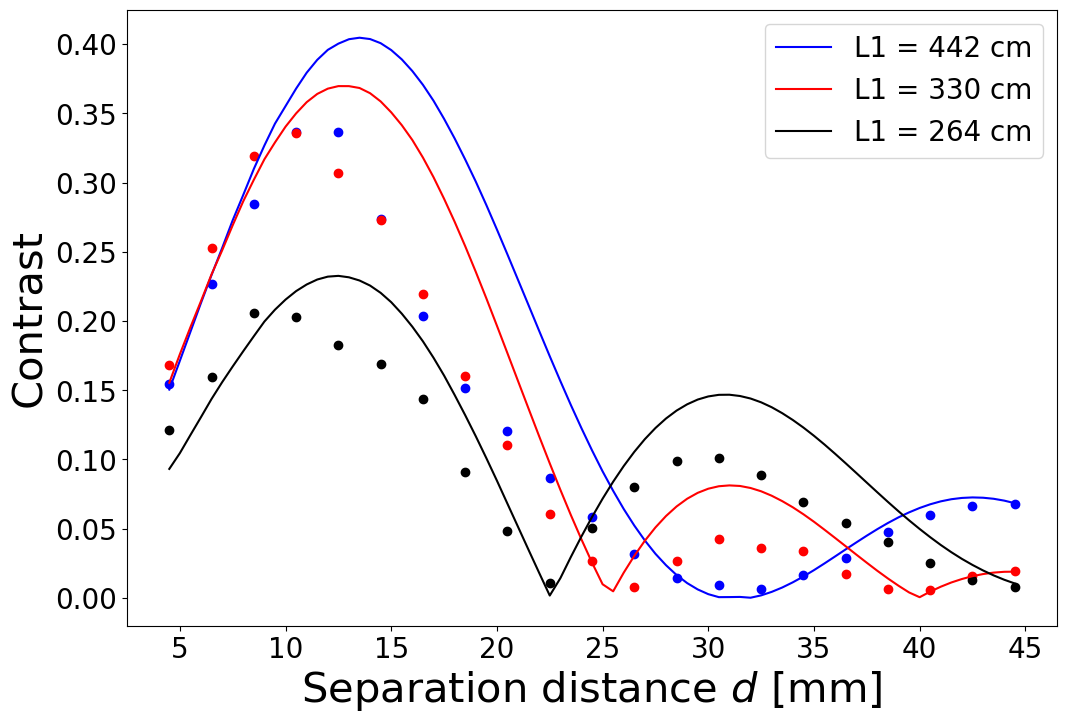

In [110]:

fig, ax1 = plt.subplots(figsize = (12,8))

datacont = datacont_c
datafreq = datafreq_c

markers = ["1","<","o","v","p","h","+",">", "d", "2", "3"]



ax1.set_prop_cycle(color = ["blue","red","black"])

for i, monoind in enumerate(monoindices):
    ax1.plot((ddata)*1e3, datacont[monoind], "o" )



ax1.set_prop_cycle(color = ["blue","red","black"])



[ax1.plot((jpd)*1e3, contjpmono[:,i] * I0_arr[i], label = "L1 = %.f cm" % ((L1jp-a).squeeze()[0,i] * 1e2)) for i, monoind in enumerate(monoindices)]


# for resind, res in enumerate(res_vals):
#     for i, monoind in enumerate(monoindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjpmonores[resind,:,i],markers[resind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, res size %.f um" % (L1jp.squeeze()[0,i] * 1e2, res*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])





    
# ax1.plot((jpd)*1e3, contjpmonoaslit[60,7,2,:,0] )
# ax1.plot((jpd)*1e3, contjpmonoaslit[60,13,2,:,1] )
# ax1.plot((jpd)*1e3, contjpmonoaslit[40,17,2,:,2] )





# ax1.set_title(r"JPARC Monochromatic Contrast with L = %f m, $d_0$ = [%.2f,%.2f,%.2f] mm, Detector Distance = %.3f m" % (Ljp, *(d0data*1e3), detector_dist))
ax1.set_xlabel("Separation distance $d$ [mm]", fontsize = 30)
ax1.set_ylabel("Contrast", fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax1.legend(fontsize = 20)
fig.savefig("JPARCMonoCont.png")
plt.show()

In [2305]:
jpslits

array([0.0004  , 0.000425, 0.00045 , 0.000475, 0.0005  , 0.000525,
       0.00055 , 0.000575, 0.0006  ])

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))




ax1.set_prop_cycle(color = ["blue","red","black"])

for i, polyind in enumerate(polyindices):
    ax1.plot(ddata*1e3, datacont[polyind], "o", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2) )

    

# for i, polyind in enumerate(polyindices):
#     ax1.plot((ddata + d0data[i])*1e3, datacont[polyind], "--o", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2) )

# for i, polyind in enumerate(polyindices):
#     ax1.plot((ddata + d0data[i])*1e3, contregion[polyind], "-d", label = "Data, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2) )  
    
ax1.set_prop_cycle(color = ["blue","red","black"])

# for slitind, slit in enumerate(jpslits):
#     for i, polyind in enumerate(polyindices):
#             ax1.plot((jpd + d0data[i])*1e3, contjppolyslit[slitind,:,i],markers[slitind] + "-" ,\
#                  label = "Simulation, L1 = %.2f cm, slit size %.f um" % (L1jp.squeeze()[0,i] * 1e2, slit*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])

# for aind, a in enumerate(a_vals):
#     for i, polyind in enumerate(polyindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjppolya[aind,:,i],markers[aind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, a = %.f cm" % (L1jp.squeeze()[0,i] * 1e2, a*1e2))
#     ax1.set_prop_cycle(color = ["blue","red","black"])


# [ax1.plot((jpd + 2*d0data[i])*1e3, contjppoly[:,i]*0.85, label = "Simulation, L1 = %.2f cm" % (L1jp.squeeze()[0,i] * 1e2)) for i, polyind in enumerate(polyindices)]

# for resind, res in enumerate(res_vals):
#     for i, polyind in enumerate(polyindices):
#         ax1.plot((jpd + d0data[i])*1e3, contjppolyres[resind,:,i],markers[resind] + "-" ,\
#             label = "Simulation, L1 = %.2f cm, res size %.f um" % (L1jp.squeeze()[0,i] * 1e2, res*1e6))
#     ax1.set_prop_cycle(color = ["blue","red","black"])




    
ax1.plot((jpd)*1e3, contjppolyaslit[75,0,5,:,0] )
ax1.plot((jpd)*1e3, contjppolyaslit[65,3,5,:,1] )
ax1.plot((jpd)*1e3, contjppolyaslit[75,4,5,:,2] )
# [ax1.plot((jpd)*1e3, contjppolyaslit[75,i,2,:,2]) for i in range(6)]


ax1.set_title("JPARC Polychromatic Contrast vs. G1-G2 separation, runs of variable L1 distance")
ax1.set_xlabel("G1-G2 separation")
ax1.set_ylabel("Contrast")
ax1.legend(fontsize = 6)
# fig.savefig("jparcpolycontdataregions.jpg")
plt.show()

### 2D Grating JPARC Data

In [ ]:
t0 = time()

exp2path = r"C:\Users\gabri\Documents\Python Scripts\JPARC experiment\exp2"




exp2polyfiltered = np.array([[process_tfl(img, -7.8, 5)[20:image_side - 100, 20:image_side - 100] for img in np.array(tfl.imread(exp2path  + "\\" + path))]\
                         for i, path in enumerate(os.listdir(exp2path)[-2:-1])]).squeeze()

print(time() - t0, "seconds")

In [ ]:
poly2ddataIx = np.sum(exp2filtered, axis = -2)
poly2ddataIy = np.sum(exp2filtered, axis = -1)
poly2dx = np.arange(poly2ddataIx.shape[-1])*cm_per_pixel*1e-2
poly2dy = np.arange(poly2ddataIy.shape[-1])*cm_per_pixel*1e-2

# pxdata, pydata = 2.97e-6, 2.9e-6
pxdata, pydata = 3e-6, 3e-6

Ldata = 8.2955 
# Ldata = 8.352789
d02d = 0
d2data = np.linspace(4.5,18.5,8)*1e-3 - d02d



In [ ]:
# exp2monofiltered = np.array([process_tfl(img,14,5) for img in tfl.imread(exp2path  + "\\" + "NID019772_20230217.tiff")])


exp2mono = np.array([process_tfl(img[...,275:875,200:850],14,5,filter_flag=False) for img in tfl.imread(exp2path  + "\\" + "NID019772_20230217.tiff")])

In [ ]:
mono2ddataIx = np.sum(exp2mono, axis = -2)
mono2ddataIy = np.sum(exp2mono, axis = -1)
mono2dx = np.arange(mono2ddataIx.shape[-1])*cm_per_pixel
mono2dy = np.arange(mono2ddataIy.shape[-1])*cm_per_pixel


In [ ]:
poly2ddataIxfitparams = np.array([best_fit_moire_period(cosine_func, poly2dx, poly2ddataIx[i], pxdata, Ldata, d2data[i]) for i in range(len(d2data))])
poly2ddataIyfitparams = np.array([best_fit_moire_period(cosine_func, poly2dy, poly2ddataIy[i], pydata, Ldata, d2data[i]) for i in range(len(d2data))])

# poly2ddataIxfitparams = np.array([curve_fit(cosine_func,poly2dx, poly2ddataIx[i],\
#                         p0 = [np.mean(poly2ddataIx[i]), np.max(poly2ddataIx[i]) - np.mean(poly2ddataIx[i]),Ldata*pxdata/d2data[i],0],\
#                         maxfev = int(3e4))[0] for i in range(len(d2data))])
# poly2ddataIyfitparams = np.array([curve_fit(cosine_func,poly2dy, poly2ddataIy[i],\
#                         p0 = [np.mean(poly2ddataIy[i]), np.max(poly2ddataIy[i]) - np.mean(poly2ddataIy[i]),Ldata*pydata/d2data[i],0],\
#                         maxfev = int(3e4))[0] for i in range(len(d2data))])



# mono2ddataIxfitparams = np.array([best_fit_moire_period(cosine_func, mono2dx, mono2ddataIx[i], pxdata, Ldata, d2data[i]) for i in range(len(d2data))])
# mono2ddataIyfitparams = np.array([best_fit_moire_period(cosine_func, mono2dy, mono2ddataIy[i], pydata, Ldata, d2data[i]) for i in range(len(d2data))])
# incorrect currently

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
ax.imshow(exp2polyfiltered[5])
# ax.axvline(860)
# fig.savefig("exp2polyfiltered.jpg")
plt.show()
plt.close(fig)

In [ ]:

exp2polycontx = np.abs(poly2ddataIxfitparams[...,1]/poly2ddataIxfitparams[...,0])
exp2polyconty = np.abs(poly2ddataIyfitparams[...,1]/poly2ddataIyfitparams[...,0])

exp2polyfreqx = 1/poly2ddataIxfitparams[...,2]
exp2polyfreqy = 1/poly2ddataIyfitparams[...,2]

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

ind = 2
# ax1.plot(poly2dy,poly2ddataIy[ind], label = "Data Along y")
ax1.plot(poly2dx,poly2ddataIx[ind], label = "Data Along x")

ax1.set_prop_cycle(None)

# ax1.plot(poly2dy,cosine_func(poly2dy,*poly2ddataIyfitparams[ind]), "--",label = "Fit Along y")
ax1.plot(poly2dx,cosine_func(poly2dx,*poly2ddataIxfitparams[ind]), "--",label = "Fit Along x")


ax1.set_xlabel("Camera x-axis (cm)")
ax1.legend()

# fig.savefig("exp2polyIydatawithfit.jpg")

plt.show()
plt.close(fig)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,12))

# ax1.imshow(exp2mono[36])

ax1.plot(mono2dy,mono2ddataIy[36], label = "Along y")
ax1.plot(mono2dx,mono2ddataIx[36], label = "Along x")

ax1.set_prop_cycle(None)

ax1.plot(mono2dy,cosine_func(mono2dy,*mono2ddataIyfitparams[36]), "--",label = "Fit Along y")
ax1.plot(mono2dx,cosine_func(mono2dx,*mono2ddataIxfitparams[36]), "--",label = "Fit Along x")


ax1.legend()
# fig.savefig("exp2monoIydata.jpg")
plt.show()
plt.close(fig)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(d2data*1e3, exp2polycontx*1e2, "x", label = "Along x")
ax1.plot(d2data*1e3, exp2polyconty*1e2, "x", label = "Along y")

ax1.set_xlabel("d (mm)")
ax1.set_ylabel("Contrast (%)")
ax1.set_title("2D Gratings Contrast vs. d")
ax1.legend()
# fig.savefig("exp2contvd.jpg")
plt.show()
plt.close(fig)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(d2data*1e3, exp2polyfreqx/1e3, "x", label = "Along x")
ax1.plot(d2data*1e3, exp2polyfreqy/1e3, "x", label = "Along y")

ax1.set_xlabel("d (mm)")
ax1.set_ylabel(r"Frequency $(mm^{-1})$")
ax1.set_title("2D Gratings Frequency vs. d")
ax1.legend()
# fig.savefig("exp2freqvd.jpg")
plt.show()
plt.close(fig)

### 2D Gratings Simulation Testing

In [760]:
px, py = 3e-6, 3e-6

Nbc = 5e28*4.149e-15
mt = 5
x0 = 0


L1mono = 1.2

L0mono = -0.05

Lmono = 2.99 - L0mono


# polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
# polyspectrum[0]*=1e-9

lammono = np.array([4.4e-10])
plammono = np.array([1])


# lampoly, plampoly = polyspectrum.copy()


h = 0.27*pi / (Nbc*4.4e-10)
# hpoly = 0.2*pi / (Nbc*5e-10)

phimono = Nbc*lammono*h

# phipoly = Nbc*lampoly*hpoly


camsize = 5e-4
slitx = 500e-6
# slitxrange = np.linspace(180,300,13)*1e-6
# slitxpolyrange = np.linspace(450,600,16)*1e-6


slity = 500e-6
xbin = 1e-6
ybin = 1e-6
res = 100e-6
# respoly = 150e-6

# Ioff = np.linspace(-5000,5000,10)



G1sdmono = {"px":px, "py":py,"L1": np.array([L1mono]), "phi":phimono}
G1sdmono["L2"] = np.linspace(11,16,1)*1e-3 


G2sdmono = {"px":px, "py":py, "L1": G1sdmono["L1"] +  G1sdmono["L2"], "phi":phimono}
G2sdmono["L2"] = Lmono - (G1sdmono["L1"] + G1sdmono["L2"])




# G1sdpoly = {"p":p, "L1": np.array([L1poly]), "phi":phipoly}
# G1sdpoly["L2"] = np.linspace(7,16,10)*1e-3 + d0["poly"]


# G2sdpoly = {"p":p, "L1": G1sdpoly["L1"] +  G1sdpoly["L2"], "phi":phipoly}
# G2sdpoly["L2"] = Lpoly - (G1sdpoly["L1"] + G1sdpoly["L2"])


simaptsmono = {"G1":RectGrating2D(G1sdmono),"G2":RectGrating2D(G2sdmono)}
siminitmono = {"lam":lammono, "plam": plammono, "L":Lmono,"d":G1sdmono["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),\
               "y": np.linspace(0,camsize,int(camsize/ybin)),"x0" : x0,"xbin":xbin,"ybin":ybin,"pos":np.array([[0],[0],[1]]),\
               "camsize" : camsize,"convmode" : "valid", "slitx": slitx, "slity" : slity,"res": res, "batches" : 1000}

# simaptspoly = {"G1":RectGrating(G1sdpoly),"G2":RectGrating(G2sdpoly)}
# siminitpoly = {"lam":lampoly, "plam": plampoly, "L":Lpoly,"d":G1sdpoly["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
#            "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid", "slitx": slitxpoly, "slity" : slity, "res": respoly, "batches" : 2000}




In [ ]:
t0 = time()

sim2d = PGMI(simaptsmono, siminitmono)
sim2d.propagate_to("G1")
sim2d.propagate_to("G2")
sim2d.generate_after("G2")

print(time() - t0, "seconds")


In [ ]:
raw2dtest = np.swapaxes(sim2d.raw,0,-1)
raw2dtest = np.reshape(raw2dtest,(500,500))

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
ax.imshow(raw2dtest)
plt.show()
plt.close(fig)

### Source Grating 2PGMI

In [345]:
Lsg = 8
phisg = np.array([pi/2])
L1sg = 4

psg = 2.4e-6
# source_period = 200e-6

# duty_vals = 1/np.array([10,4,2])


polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9

lamsg, plamsg = np.array([5e-10]), np.ones(1)
# lamsg, plamsg = polyspectrum

mt = 5
x0 = np.array([0])



camsize = 1e-2



xbin = 1e-6
ybin = 1e-6
ressg = 100e-6
slitsg = 100e-6
dp2overlam = psg**2/lamsg[np.argmax(plamsg)]


# sgp_vals = Lsg * psg / dp2overlam / np.array([5,3,2,1, 1/0.9])
sgp_vals = np.array([1.5,1])*Lsg*lamsg/psg

# sgp_vals = Lsg * psg / dp2overlam / np.array([5])
# sgp_vals = np.arange(1,5,1)*1e-4

dsg = np.linspace( 5, 18, 60)*1e-3


G1sdsg = {"p":psg, "L1": np.array([L1sg]), "phi":phisg}
G1sdsg["L2"] = dsg



G2sdsg = {"p":psg, "L1": G1sdsg["L1"] +  G1sdsg["L2"], "phi":phisg}
G2sdsg["L2"] = Lsg - (G1sdsg["L1"] + G1sdsg["L2"])



simaptssg = {"G1":RectGrating(G1sdsg),"G2":RectGrating(G2sdsg)}
siminitsg = {"lam":lamsg, "plam": plamsg, "L":Lsg,"d":G1sdsg["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin) + 1),\
                 "x0" : x0,"xbin":xbin,"ybin":ybin,"pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid",\
                 "slitx":slitsg,"res": ressg, "batches" : 5000}


(5000, 60, 2) after parallel
(60, 10000) after reshape
(60, 10000) before convolution


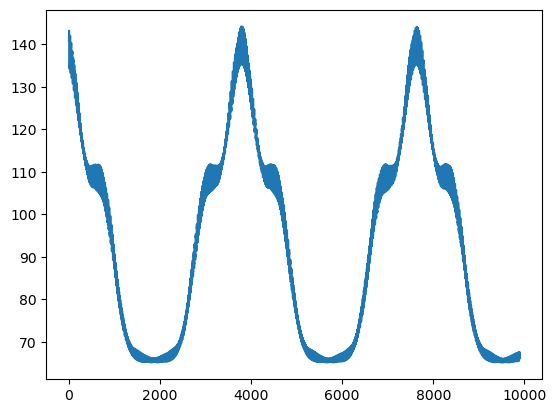

Finding contrast


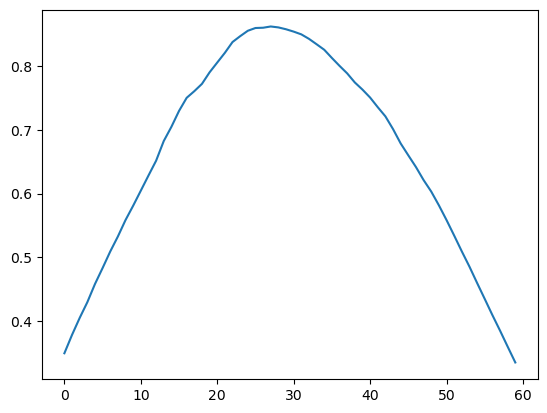

16.868733167648315 seconds


In [346]:
t0 = time()

simsg = PGMI(simaptssg,siminitsg)

simsg.propagate_to("G1")
simsg.propagate_to("G2")
simsg.generate_after("G2")

contenvel = simsg.get_value("contrast")
plt.plot(contenvel)
plt.show()
print(time() - t0, "seconds")




0.0025000000000000005
0.5
(5000, 60, 2) after parallel
(60, 10000) after reshape
(60, 10000) before convolution


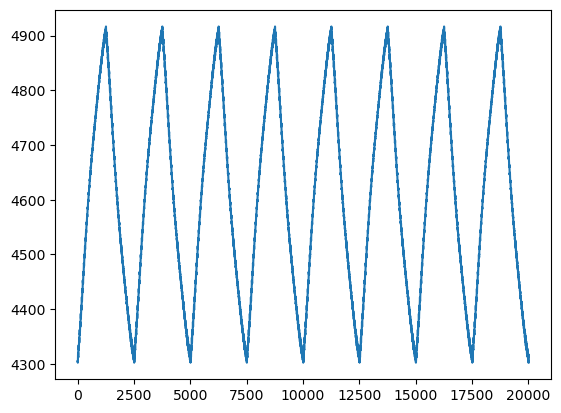

Finding contrast
0.0016666666666666668
0.5
(5000, 60, 2) after parallel
(60, 10000) after reshape
(60, 10000) before convolution


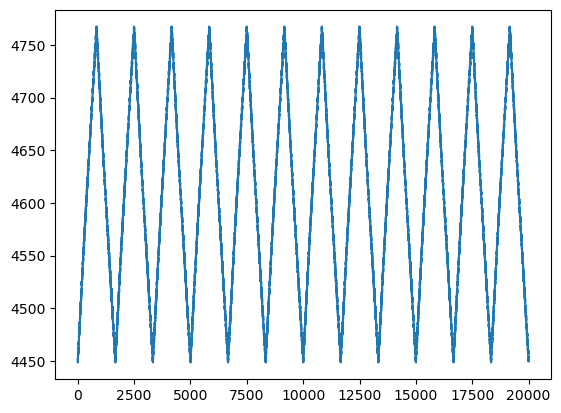

Finding contrast
29.148075580596924 seconds


In [347]:
t0 = time()

duty_cycle = 0.5

contsgp50 = []
Isgp50 = []
fitparamssgp50 = []




for sgp in sgp_vals:
    siminitsg = {"lam":lamsg, "plam": plamsg, "L":Lsg,"d":G1sdsg["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin) + 1),\
                 "x0" : x0,"xbin":xbin,"ybin":ybin,"pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid",\
                 "source_period":sgp, "duty_cycle":duty_cycle,"res": ressg, "batches" : 5000}
   
    print(sgp)
    print(duty_cycle)
    simsg = PGMI(simaptssg,siminitsg)
    simsg.propagate_to("G1")
    simsg.propagate_to("G2")
    simsg.generate_after("G2")
    
    contsgp50.append(simsg.get_value("contrast"))
    Isgp50.append(simsg.get_value("intensity"))
    fitparamssgp50.append(simsg.get_value("fitparams"))
    
    
    
print(time() - t0, "seconds")


0.0025000000000000005
0.1
(5000, 60, 2) after parallel
(60, 10000) after reshape
(60, 10000) before convolution


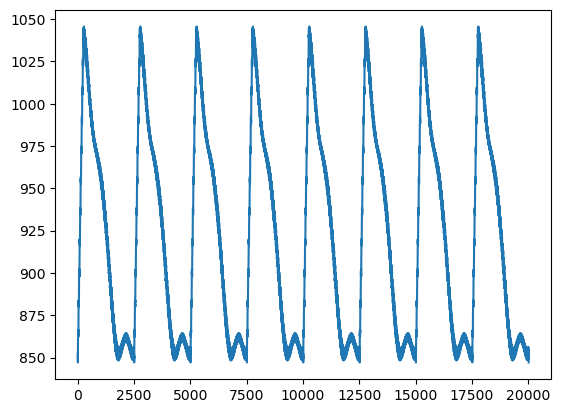

Finding contrast
0.0016666666666666668
0.1
(5000, 60, 2) after parallel
(60, 10000) after reshape
(60, 10000) before convolution


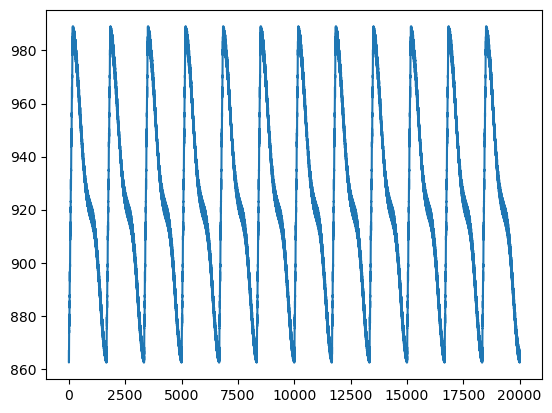

Finding contrast
27.141194105148315 seconds


In [348]:
t0 = time()

duty_cycle = 0.1

contsgp10 = []
Isgp10 = []
fitparamssgp10 = []

for sgp in sgp_vals:
    siminitsg = {"lam":lamsg, "plam": plamsg, "L":Lsg,"d":G1sdsg["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin) + 1),\
                 "x0" : x0,"xbin":xbin,"ybin":ybin,"pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid",\
                 "source_period":sgp, "duty_cycle":duty_cycle,"res": ressg, "batches" : 5000}
   
    print(sgp)
    print(duty_cycle)
    simsg = PGMI(simaptssg,siminitsg)
    simsg.propagate_to("G1")
    simsg.propagate_to("G2")
    simsg.generate_after("G2")
    
    contsgp10.append(simsg.get_value("contrast"))
    Isgp10.append(simsg.get_value("intensity"))
    fitparamssgp10.append(simsg.get_value("fitparams"))
    
print(time() - t0, "seconds")


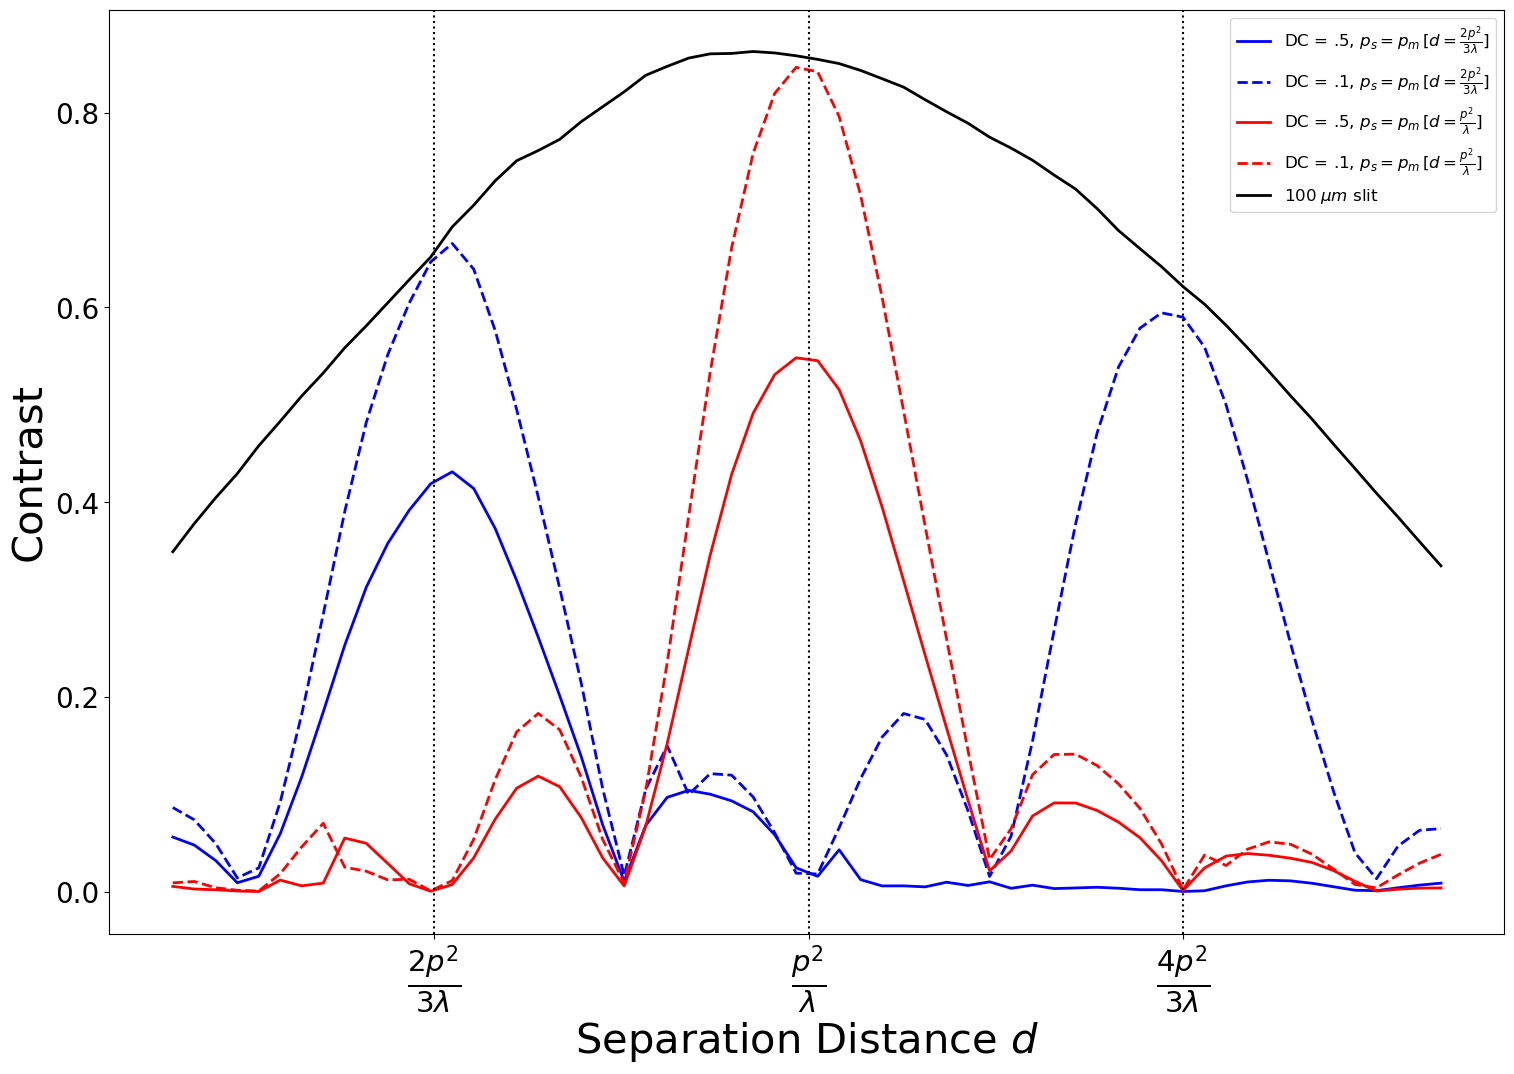

In [349]:
fig, ax1 = plt.subplots(figsize = (18,12))
dlamarr = np.array([2/3,1,4/3])*dp2overlam*1e3
dlamlabels = [r"$\frac{2p^{2}}{3\lambda}$", r"$\frac{p^{2}}{\lambda}$", r"$\frac{4p^{2}}{3\lambda}$" ]

ax1.set_prop_cycle(color = ["blue","blue","black"])

ax1.plot(simsg.d*1e3, contsgp50[0], lw = 2, label = r"DC = .5, $p_s = p_m \,[d = \frac{2p^{2}}{3\lambda}]$" % (sgp_vals[0] / (Lsg*psg/dp2overlam)) )
ax1.plot(simsg.d*1e3, contsgp10[0], "--", lw = 2, label = r"DC = .1, $p_s = p_m \,[d = \frac{2p^{2}}{3\lambda}]$" % (sgp_vals[0] / (Lsg*psg/dp2overlam)) )


ax1.set_prop_cycle(color = ["red","red","black"])
ax1.plot(simsg.d*1e3, contsgp50[1], lw = 2, label = r"DC = .5, $p_s = p_m \,[d = \frac{p^{2}}{\lambda}]$" % (sgp_vals[1] / (Lsg*psg/dp2overlam)) )

ax1.plot(simsg.d*1e3, contsgp10[1], "--", lw = 2, label = r"DC = .1, $p_s = p_m \,[d = \frac{p^{2}}{\lambda}]$" % (sgp_vals[1] / (Lsg*psg/dp2overlam)) )

ax1.plot(simsg.d*1e3, contenvel, lw = 2, label = r"$%.f \; \mu m$ slit" % (slitsg*1e6))


ax1.set_xlabel("Separation Distance $d$", fontsize = 30)
ax1.set_ylabel("Contrast", fontsize = 30)
ax1.legend(fontsize = 12)


[ax1.axvline(dlamarr[i], color = "black", ls = "dotted", label = dlamlabels[i]) for i in range(len(dlamarr))]

ax1.tick_params(axis = "x", labelsize = 30)
ax1.tick_params(axis = "y", labelsize = 20)

ax1.set_xticks(dlamarr)
ax1.set_xticklabels(dlamlabels)



# fig.savefig("SourceGratingContrast.png")
plt.show()
plt.close(fig)

### Cont Density L1 d Figure

In [4]:
dsg = np.linspace(2, 37,106) *1e-3
slitdens = 200e-6
xbin = 0.5e-6
dsg, L1dens = force_broadcast(dsg, np.linspace(Lsg/4,3*Lsg/4,120))

G1sdsg = {"p":psg, "L1": L1dens, "phi":phisg}
G1sdsg["L2"] = dsg



G2sdsg = {"p":psg, "L1": G1sdsg["L1"] +  G1sdsg["L2"], "phi":phisg}
G2sdsg["L2"] = Lsg - (G1sdsg["L1"] + G1sdsg["L2"])


simaptssg = {"G1":RectGrating(G1sdsg),"G2":RectGrating(G2sdsg)}
siminitsg = {"lam":lamsg, "plam": plamsg, "L":Lsg,"d":G1sdsg["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid","slitx":slitdens, "res": ressg, "batches" : 25000}

In [5]:
t0 = time()



simdens = PGMI(simaptssg,siminitsg)
simdens.propagate_to("G1")
simdens.propagate_to("G2")
simdens.generate_after("G2")

print(time() - t0, "seconds")

(25000, 106, 120, 2) after parallel
(106, 120, 50000) after reshape
(106, 120, 50000) before convolution
Finding contrast
33012.36265087128 seconds


In [2508]:
simdens.stepslitx.shape[-1]

51

In [14]:
p2lam_mult = dp2overlam*np.linspace(1,6,6)/2
print(p2lam_mult)
print(dsg[np.argmin(abs(dsg[:,None] - p2lam_mult[None,:]),axis = 0)])


[0.00576 0.01152 0.01728 0.02304 0.0288  0.03456]
[0.00566667 0.01166667 0.01733333 0.023      0.02866667 0.03466667]


In [ ]:
rawdens = simdens.raw[:,simdens.raw.shape[-2]//2]
slitdens, resdens = generate_stepfunc(200e-6,xbin), generate_stepfunc(100e-6,xbin)
rawdens, slitdens = force_equal_dims(rawdens,slitdens)
rawdens, resdens = force_equal_dims(rawdens, resdens)

convdens = oaconvolve(oaconvolve(rawdens, slitdens,axes = -1,mode = "valid"), resdens, axes = -1, mode = "valid")
print(convdens.shape,slitdens.shape,resdens.shape)
densx = np.linspace(0,camsize,convdens.shape[-1])

In [ ]:
fitparamsLover2 = np.array([best_fit_moire_period(cosine_func,densx,convdens[i],psg,Lsg,dsg[i]) for i in range(convdens.shape[0])])
contLover2 = np.abs(fitparamsLover2[...,1]/fitparamsLover2[...,0])

In [84]:
L1jpratio = (L1jp[0] -a)/Ljp * Lsg
print(L1jpratio)


[4.22965429 3.16253017 2.52608394]


In [85]:
Ljp

8.35891517571597

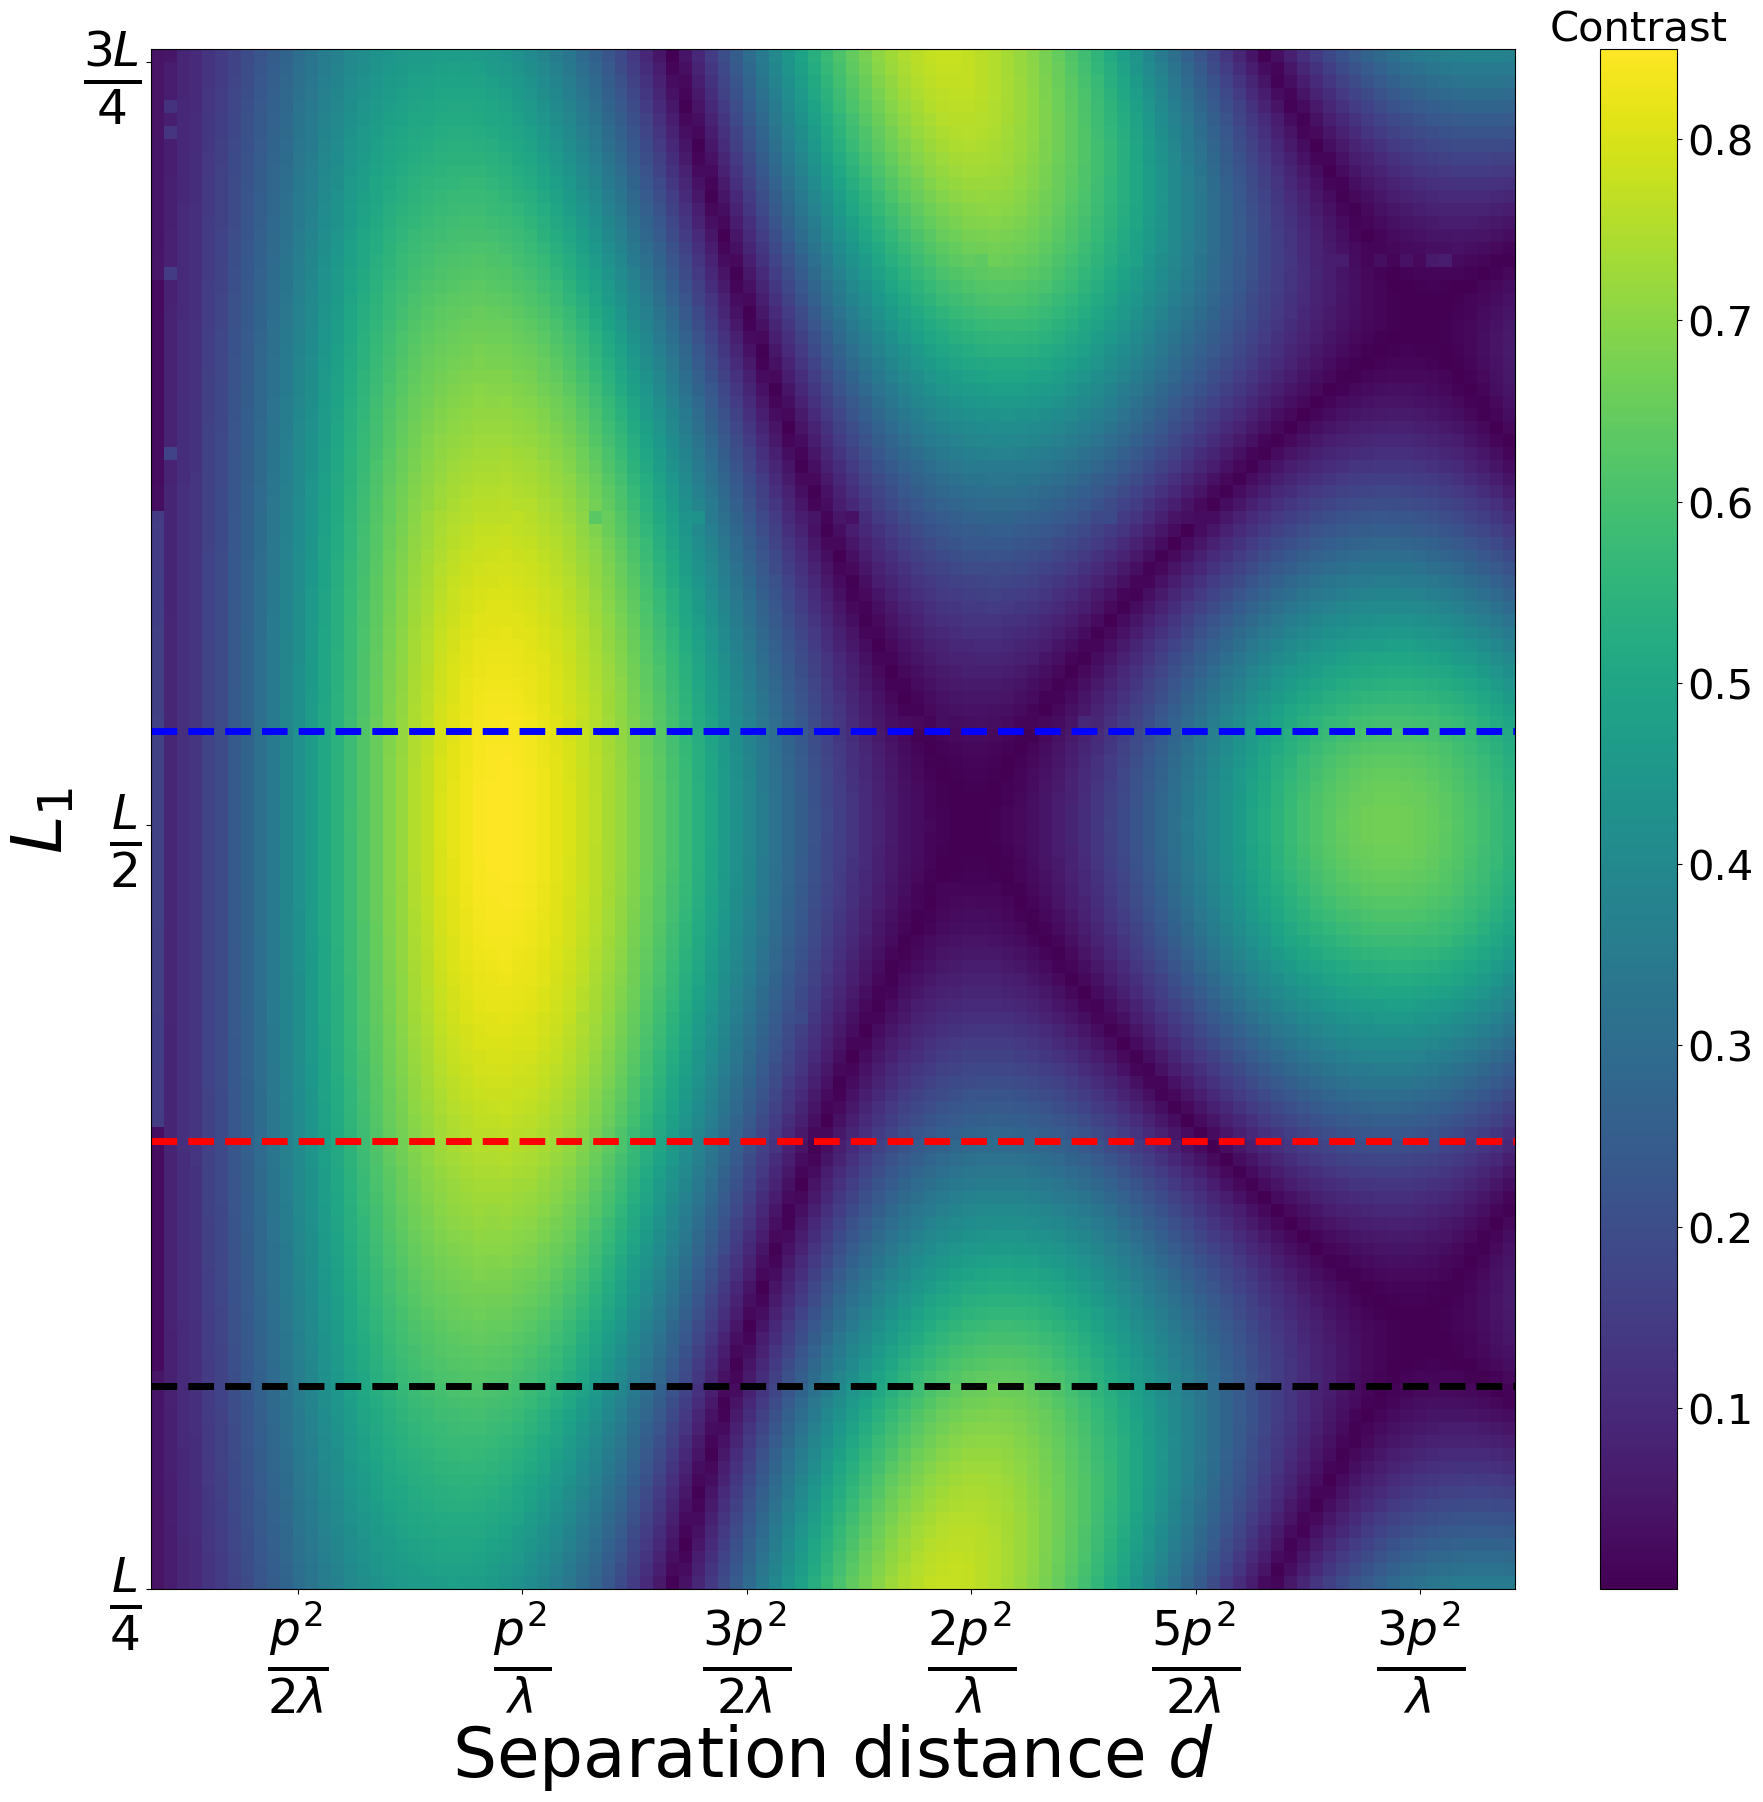

In [135]:
L1dens = L1dens.squeeze()
dsg = dsg.squeeze()
fig,ax = plt.subplots(figsize = (22,20))
c = ax.imshow(simdens.contrast.T, aspect = "auto", origin = "lower", extent = (dsg[0],dsg[-1],L1dens[0],L1dens[-1],))
cbar = fig.colorbar(c)
cbar.ax.tick_params(labelsize = 30)
cbar.ax.set_title("Contrast", fontsize = 30)

ax.set_yticks(L1dens[::len(L1dens)//2 -1])
ax.set_yticklabels([r"$\frac{L}{4}$",r"$\frac{L}{2}$",r"$\frac{3L}{4}$"], fontsize = 50)
ax.set_xticks(p2lam_mult)
ax.set_xticklabels([r"$\frac{p^2}{2\lambda}$",r"$\frac{p^2}{\lambda}$",r"$\frac{3p^2}{2\lambda}$",r"$\frac{2p^2}{\lambda}$",\
                   r"$\frac{5p^2}{2\lambda}$",r"$\frac{3p^2}{\lambda}$"], fontsize = 50)

ax.axhline(L1jpratio[0], color = "blue", ls = "--", linewidth = 5)
ax.axhline(L1jpratio[1], color = "red", ls = "--", linewidth = 5)
ax.axhline(L1jpratio[2], color = "black", ls = "--", linewidth = 5)

ax.set_xlabel(r"Separation distance $d$", fontsize = 50)
ax.set_ylabel(r"$L_1$", fontsize = 50)
# ax.axvline(dp2overlam/2)
fig.savefig("contL1figure.png")

plt.show()
plt.close(fig)

In [ ]:
freqLover2 = 1/fitparamsLover2[...,2]
print(freqLover2.shape)

In [ ]:
fig,ax1 = plt.subplots(figsize = (12,8))
ax1.plot(dsg*1e3,simdens.contrast[:,simdens.contrast.shape[-1]//2], label = "No slit")
ax1.plot(dsg*1e3,contLover2, label = "Slit size 200 micron")

ax2 = ax1.twinx()

ax2.plot(dsg*1e3, 1/simdens.fitparams[:,simdens.contrast.shape[-1]//2,2], label = "No slit")
ax2.plot(dsg*1e3, freqLover2, label = "Slit size 200 micron")

ax1.legend()
ax2.legend()
# fig.savefig("contL1atLover2.jpg")

plt.show()
plt.close(fig)

### Fork Grating Testing

In [ ]:
pfork = 2.1e-6

mt = 5
x0 = 0

Lfork = 8
phifork = np.array([pi/2])
L1fork = 4

pfork = 2.4e-6


polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9

lamfork, plamfork = np.array([5e-10]), np.ones(1)
# lamfork, plamfork = polyspectrum

mt = 5
x0 = np.array([0])

Nbc = 5e28*4.149e-15


camsize = 2.5e-2



xbin = 1e-6
ybin = 1e-6
resfork = 100e-6

dp2overlam = pfork**2/lamfork[np.argmax(plamfork)]
print(dp2overlam)
forkp_vals = Lfork * pfork / dp2overlam / np.array([1])



G1sdfork = {"p":pfork, "L1": np.array([L1fork]), "phi":phifork}
G1sdfork["L2"] = np.linspace( dp2overlam/ 2, 3 * dp2overlam/ 2,41) 


G2sdfork = {"p":pfork, "L1": G1sdfork["L1"] +  G1sdfork["L2"], "phi":phifork}
G2sdfork["L2"] = Lfork - (G1sdfork["L1"] + G1sdfork["L2"])


# Ioff = np.linspace(-5000,5000,10)
simaptsfork = {"G1":RectGrating(G1sdfork),"G2":RectGrating(G2sdfork)}
siminitfork = {"lam":lamfork, "plam": plamfork, "L":Lfork,"d":G1sdfork["L2"],"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"x0" : x0,"xbin":xbin,"ybin":ybin,\
           "pos":np.array([[0],[1]]) ,"camsize" : camsize ,"convmode" : "valid", "res": resfork, "batches" : 1000}


